<a href="https://colab.research.google.com/github/jaehyun0220/Colab/blob/master/SDS_FeatureEngineering_Sampling_Template_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3조. 건강검진 데이터를 활용한 치아우식증 발생 예측

## - Version 4. 외부 변수 결합 후 scoring 모델 전환

## 1. 작업 환경 세팅

### 1-1. 구글 드라이브 인증

In [1]:
# Auth 인증 및 Google Drive 활용 Data load
# from google.colab import auth
# auth.authenticate_user()
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

# 학교 g guite 사용 시: 학교 g suite 구글 드라이브에 연결해 놓았으니, 성대 킹고 로그인해서 구글 드라이브 켜놓고 아래 결과창에 나오는 url 클릭해서 성대 gmail로 로그인하면 됨
# 데이터 경로는 본인 drive 내의 /sds/data 경로로 fixdm

# Google Drive 내 Custom Class 경로 지정
import sys
sys.path.insert(0, '/gdrive/My Drive/CustomClasses')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
!ls /gdrive/My\ Drive/sds/data

 완료_구강검진결과_14년도_교육이후개별비.csv
 완료_구강검진결과_14년도_총수검인원기준비.csv
 chs11_all.txt
 chs12_all.txt
 chs13_all.txt
 chs14_all.txt
 chs15_all.txt
 chs16_all.txt
 chs17_all.xls
'완료_KOSIS 연령별 성별 치과 평균 수진횟수 2012.csv'
'완료_KOSIS 치주질환 유병률 추이_2012.csv'
 nanum
 NHIS_OPEN_GJ_2010.csv
 NHIS_OPEN_GJ_2011.csv
 NHIS_OPEN_GJ_2012.csv
 NHIS_OPEN_GJ_2013.csv
 NHIS_OPEN_GJ_2014.csv
 NHIS_OPEN_GJ_2015.csv
 NHIS_OPEN_GJ_2016.csv
 NHIS_OPEN_GJ_2017.csv
'NHIS_OPEN_GJ 건강검진 데이터 연도별 데이터 레이아웃.xlsx'
 NHIS_OPEN_T20_2012.csv
 NHIS_OPEN_T20_2013.csv
 NHIS_OPEN_T20_2014.csv
 NHIS_OPEN_T20_2015.csv
 NHIS_OPEN_T20_2016.csv
 NHIS_OPEN_T20_2017.csv
'NHIS_OPEN_T20 진료내역정보_활용방안.txt'


### 1-2. 라이브러리 로딩

In [3]:
# 기본 라이브러리 로드
import pandas as pd
import numpy as np
import os, sys

from tqdm import tqdm_notebook

import re
import tensorflow as tf

#데이터 전처리 관련 라이브러리 로드
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit

#모델 알고리즘 로드
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier

# Deep Learning Model 로드
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation 
from keras.wrappers.scikit_learn import KerasClassifier

#HyperParameter Tuning을 위한 라이브러리 로드
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#모델 평가를 위한 라이브러리 로드
from sklearn import metrics, model_selection
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc

#수학 & 통계 관련 라이브러리 로드
import scipy.stats as st
from collections import Counter
import math

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Visualization
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도
import seaborn as sns

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

Using TensorFlow backend.


In [6]:
!wget "https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip" 

--2019-10-29 04:34:11--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 64.233.188.128, 2404:6800:4008:c06::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121163981 (116M) [application/zip]
Saving to: ‘NotoSansCJKkr-hinted.zip’

NotoSansCJKkr-hinte 100%[===================>] 115.55M  59.4MB/s    in 1.9s    

2019-10-29 04:34:13 (59.4 MB/s) - ‘NotoSansCJKkr-hinted.zip’ saved [121163981/121163981]



In [21]:
!unzip NotoSansCJKkr-hinted.zip

Archive:  NotoSansCJKkr-hinted.zip
replace LICENSE_OFL.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: LICENSE_OFL.txt         
replace NotoSansCJKkr-Black.otf? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace NotoSansCJKkr-Black.otf? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: NotoSansCJKkr-Black.otf  
  inflating: NotoSansCJKkr-Bold.otf  
  inflating: NotoSansCJKkr-DemiLight.otf  
  inflating: NotoSansCJKkr-Light.otf  
  inflating: NotoSansCJKkr-Medium.otf  
  inflating: NotoSansCJKkr-Regular.otf  
  inflating: NotoSansCJKkr-Thin.otf  
  inflating: NotoSansMonoCJKkr-Bold.otf  
  inflating: NotoSansMonoCJKkr-Regular.otf  
  inflating: README                  


In [22]:
# !mkdir /usr/share/fonts/treutype
# !mv NotoSansCJKkr-Medium.otf /usr/share/fonts/treutype/
!cp NotoSansCJKkr-Medium.otf /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf

mkdir: cannot create directory ‘/usr/share/fonts/treutype’: File exists


In [0]:
fm._rebuild()
mpl.rc('font', family="NotoSansCJKkr")

In [27]:
fm.findfont('NotoSansCJKkr')

'/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'

In [29]:
mpl.rcParams.items

<bound method Mapping.items of RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': '.15',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext

In [30]:
mpl.font_manager.FontProperties("NotoSansCJKkr").get_family()

['NotoSansCJKkr']

In [32]:
mpl.font_manager.FontProperties("sans-serif", weight="bold").get_family()

['sans-serif']

findfont: Font family ['NotoSansCJKkr-medium'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NotoSansCJKkr-medium'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NotoSansCJKkr-medium'] not found. Falling back to DejaVu Sans.


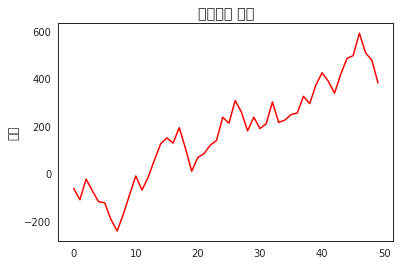

In [24]:
data = np.random.randint(-100, 100, 50).cumsum()
plt.plot(range(50), data, 'r')
plt.title('가격변동 추이')
plt.ylabel('가격')
plt.show()

## 2. 파일 Read 및 기초 탐색

In [0]:
set_random_seed = 1024
set_cv = 2

In [0]:
# DataFrame Load --------- 2개년도 기준 데이터 추출 및 병합

df_raw_2012 = pd.read_csv('../gdrive/My Drive/sds/data/NHIS_OPEN_GJ_2012.csv', encoding = 'euc-kr')
df_raw_2013 = pd.read_csv('../gdrive/My Drive/sds/data/NHIS_OPEN_GJ_2013.csv', encoding = 'euc-kr')

# 컬럼명 내 불필요한 공백 및 특수문자 제거
df_raw_2012.rename(columns=lambda x: re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》 ]', '', x), inplace=True)
df_raw_2013.rename(columns=lambda x: re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》 ]', '', x), inplace=True)

# 데이터 구조 확인
display(df_raw_2012.head(2))
display(df_raw_2013.head(2))

# 데이터 결합 및 구강검진검수여부
df_raw = pd.concat([df_raw_2012, df_raw_2013])
df_raw = df_raw[df_raw['구강검진수검여부']==1]

# len(df_raw)

#### 2013년 기준 #########################################################################################################################################
# # 참고 - 데이터 concat시 index 문제로 병합이 안되면 아래 코드 수행 후 다시 concat
# # df_raw.drop_duplicates() #df_raw.reset_index() # df_raw.info()

# df_raw_2013 = pd.read_csv('../gdrive/My Drive/sds/data/NHIS_OPEN_GJ_2013.csv', encoding = 'euc-kr')

# # 컬럼명 내 불필요한 공백 및 특수문자 제거
# df_raw_2013.rename(columns=lambda x: re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》 ]', '', x), inplace=True)
# df_raw = df_raw_2013[df_raw_2013['구강검진수검여부']==1]
# display(df_raw.sample(5))

# # 참고 - 데이터 concat시 index 문제로 병합이 안되면 아래 코드 수행 후 다시 concat
# # df_raw.drop_duplicates() #df_raw.reset_index() # df_raw.info()

####  2015년 기준 #########################################################################################################################################
# df_raw_2015 = pd.read_csv('../gdrive/My Drive/sds/data/NHIS_OPEN_GJ_2015.csv', encoding = 'euc-kr')

# # 컬럼명 내 불필요한 공백 및 특수문자 제거
# df_raw_2015.rename(columns=lambda x: re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》 ]', '', x), inplace=True)
# df_raw = df_raw_2015[df_raw_2015['구강검진수검여부']==1]
# display(df_raw.sample(5))

,기준년도,가입자일련번호,성별코드,연령대코드5세단위,시도코드,신장5Cm단위,체중5Kg단위,허리둘레,시력좌,시력우,청력좌,청력우,수축기혈압,이완기혈압,식전혈당공복혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,혈청지오티AST,혈청지오티ALT,감마지티피,흡연상태,음주여부,구강검진수검여부,치아우식증유무,결손치유무,치아마모증유무,제3대구치사랑니이상,치석,데이터공개일자
0,2012,220721,2,14,46,150,45,72,0.2,0.4,1.0,1.0,121,76,132,198,64,37,149.0,10.4,NaN,1.2,25,14,11,1.0,0.0,0,NaN,NaN,NaN,NaN,NaN,20151220
1,2012,830677,2,14,45,145,30,68,0.1,0.1,1.0,1.0,110,70,70,151,102,41,89.0,9.1,1.0,0.7,28,16,11,1.0,0.0,0,NaN,NaN,NaN,NaN,NaN,20151220


,기준년도,가입자일련번호,성별코드,연령대코드5세단위,시도코드,신장5Cm단위,체중5Kg단위,허리둘레,시력좌,시력우,청력좌,청력우,수축기혈압,이완기혈압,식전혈당공복혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,혈청지오티AST,혈청지오티ALT,감마지티피,흡연상태,음주여부,구강검진수검여부,치아우식증유무,결손치유무,치아마모증유무,제3대구치사랑니이상,치석,데이터공개일자
0,2013,24193,2,14,11,145,35,83,0.1,0.1,1.0,1.0,120,70,120,185,151,35,119.0,11.3,NaN,0.9,18,8,30,1.0,0.0,0,NaN,NaN,NaN,NaN,NaN,20151220
1,2013,134496,1,1,27,140,35,68,0.8,0.8,1.0,1.0,110,80,80,138,123,53,60.0,14.4,1.0,0.7,22,14,12,1.0,0.0,0,NaN,NaN,NaN,NaN,NaN,20151220


### 2-1. 컬럼명 정제 및 기초 탐색

In [0]:
# del_cols = ['기준년도', '가입자일련번호', '치아우식증유무', '결손치유무' ,'치아마모증유무','제3대구치사랑니이상','데이터공개일자', '구강검진수검여부','음주여부']
# 2014 & 2015년도 데이터 기준
# del_cols = ['기준년도', '가입자일련번호', '치아우식증유무', '데이터기준일자', '구강검진수검여부']
# df_raw.drop(columns=del_cols, axis=1, inplace=True)
# df_raw.rename(columns={'치석유무': '치석'}, inplace=True)

# 2012 & 2013년도 데이터 기준
del_cols = ['기준년도', '가입자일련번호', '데이터공개일자','구강검진수검여부']
df_raw.drop(columns=del_cols, axis=1, inplace=True)


# #### 2013년 기준 #########################################################################################################################################
# del_cols = ['기준년도', '가입자일련번호', '데이터공개일자','구강검진수검여부']
# df_raw.drop(columns=del_cols, axis=1, inplace=True)

# display(df_raw.head(3))
# df_raw.info()

#### 2014년 기준 #########################################################################################################################################
# del_cols = ['기준년도', '가입자일련번호', '데이터기준일자','구강검진수검여부']
# df_raw.drop(columns=del_cols, axis=1, inplace=True)
# df_raw.rename(columns={'치석유무': '치석'}, inplace=True)

# display(df_raw.head(3))
# df_raw.info()

### 2-2. 치석 데이터 분류 있으나 치석 분류가 2가 아닌 데이터만 df_data에 다시 할당

In [0]:
# 타겟 변수 지정
target_nm = '치아우식증유무'
print(df_raw[target_nm].value_counts())

# 타겟 변수 후보군 지정하여 분석시 제외
remove_target_candidates = ['치아마모증유무', '치아우식증유무', '제3대구치사랑니이상', '치석', '결손치유무']

# 모델에 따라 타겟 변수 후보군으로 제외하지 않고 입력으로 사용할 변수
not_remove_in_tg = ['치석','결손치유무']

0.0    582073
1.0    186493
Name: 치아우식증유무, dtype: int64


In [0]:
df_data = df_raw[~(df_raw['치석'].isnull()) & (df_raw['치석'] != 2)]

## 3. Simple EDA
1. 데이터 임포트 후 메모리에 upload 
2. 데이터의 모양 확인
3. 데이터의 타입 확인
4. 데이터의 Null 값을 체크
5. 종속변수의 분포 체크
6. 독립변수 - 명목형 변수의 분포 체크
7. 독립변수 - 수치형 변수의 분포 체크
8. 수치형, 명목형 변수간의 관계 파악

### 3-1. 데이터의 모양 및 타입 확인

In [0]:
# EDA 진행 할 데이터 모양 확인 및 데이터 타입 확인
display(df_data.sample(5))
display(df_data.info())

,성별코드,연령대코드5세단위,시도코드,신장5Cm단위,체중5Kg단위,허리둘레,시력좌,시력우,청력좌,청력우,수축기혈압,이완기혈압,식전혈당공복혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,혈청지오티AST,혈청지오티ALT,감마지티피,흡연상태,음주여부,치아우식증유무,결손치유무,치아마모증유무,제3대구치사랑니이상,치석
544554,2,7,31,155,50,75,0.5,0.4,1.0,1.0,126,84,106,175,51,55,110.0,13.1,1.0,0.8,16,11,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0
201324,1,4,43,170,65,88,1.5,1.5,1.0,1.0,110,70,105,175,139,54,93.0,14.5,1.0,1.1,14,9,17,2.0,0.0,1.0,0.0,0.0,0.0,0.0
640852,2,7,26,160,70,90,0.5,0.7,1.0,1.0,133,78,103,191,68,50,127.0,14.2,1.0,0.9,52,74,32,1.0,0.0,0.0,1.0,1.0,0.0,1.0
206155,1,4,29,180,95,92,1.2,1.2,1.0,1.0,130,80,179,174,379,45,53.0,14.8,1.0,1.0,57,140,68,2.0,1.0,1.0,0.0,1.0,0.0,1.0
176538,1,3,27,160,70,98,1.2,1.2,1.0,1.0,120,80,106,235,306,38,135.0,16.8,1.0,1.3,22,31,71,3.0,1.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 768562 entries, 5 to 999998
Data columns (total 30 columns):
성별코드          768562 non-null int64
연령대코드5세단위     768562 non-null int64
시도코드          768562 non-null int64
신장5Cm단위       768562 non-null int64
체중5Kg단위       768562 non-null int64
허리둘레          768562 non-null int64
시력좌           768439 non-null float64
시력우           768442 non-null float64
청력좌           768454 non-null float64
청력우           768451 non-null float64
수축기혈압         768562 non-null int64
이완기혈압         768562 non-null int64
식전혈당공복혈당      768562 non-null int64
총콜레스테롤        768562 non-null int64
트리글리세라이드      768562 non-null int64
HDL콜레스테롤      768562 non-null int64
LDL콜레스테롤      761367 non-null float64
혈색소           768562 non-null float64
요단백           765995 non-null float64
혈청크레아티닌       768562 non-null float64
혈청지오티AST      768562 non-null int64
혈청지오티ALT      768562 non-null int64
감마지티피         768562 non-null int64
흡연상태          768504 non-null float64
음주여부   

None

### 3-2. 데이터 NULL 값 체크

In [0]:
# Null Value Check
print('# Null Value Check in Data \n ---------------------------------------------------- ')
print(df_data.isnull().sum())

# Null Value Check in Data 
 ---------------------------------------------------- 
성별코드             0
연령대코드5세단위        0
시도코드             0
신장5Cm단위          0
체중5Kg단위          0
허리둘레             0
시력좌            123
시력우            120
청력좌            108
청력우            111
수축기혈압            0
이완기혈압            0
식전혈당공복혈당         0
총콜레스테롤           0
트리글리세라이드         0
HDL콜레스테롤         0
LDL콜레스테롤      7195
혈색소              0
요단백           2567
혈청크레아티닌          0
혈청지오티AST         0
혈청지오티ALT         0
감마지티피            0
흡연상태            58
음주여부           150
치아우식증유무          3
결손치유무            2
치아마모증유무          1
제3대구치사랑니이상       3
치석               0
dtype: int64


#### 3-2-1. 데이터 NULL 값의 비중이 크지 않으므로 일단 null 값을 모두 삭졔
 . 가장 많은 Null값을 갖고 있는 요단백의 경우 추후 분석 시, 모델에 끼치는 영향이 크다고 할 시, Imputation 고려

In [0]:
# (일단 임시로) null 포함 데이터 모두 삭제 
df_data.dropna(how='any', inplace=True)
display(df_data.info())
print(len(df_data))

print(df_data[target_nm].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 758436 entries, 5 to 999998
Data columns (total 30 columns):
성별코드          758436 non-null int64
연령대코드5세단위     758436 non-null int64
시도코드          758436 non-null int64
신장5Cm단위       758436 non-null int64
체중5Kg단위       758436 non-null int64
허리둘레          758436 non-null int64
시력좌           758436 non-null float64
시력우           758436 non-null float64
청력좌           758436 non-null float64
청력우           758436 non-null float64
수축기혈압         758436 non-null int64
이완기혈압         758436 non-null int64
식전혈당공복혈당      758436 non-null int64
총콜레스테롤        758436 non-null int64
트리글리세라이드      758436 non-null int64
HDL콜레스테롤      758436 non-null int64
LDL콜레스테롤      758436 non-null float64
혈색소           758436 non-null float64
요단백           758436 non-null float64
혈청크레아티닌       758436 non-null float64
혈청지오티AST      758436 non-null int64
혈청지오티ALT      758436 non-null int64
감마지티피         758436 non-null int64
흡연상태          758436 non-null float64
음주여부   

None

758436
0.0    574318
1.0    184118
Name: 치아우식증유무, dtype: int64


In [0]:
# 샘플링을 통한 데이터 분석

# # 1. 샘플링을 통해 10만건만 데이터분석
# df_sample = df_data.sample(n=100000, random_state=42, replace = False ).copy()

# 2. 0과 1을 1:1 비율로 10만건씩 추출하여 20만건 추출
df_sample = df_data.groupby(target_nm).apply(lambda x: x.sample(n=100000, random_state=set_random_seed)).copy()

# # 3. 0과 1을 특정 비율로 샘플링
# n_target0 = 180000
# n_target1 = 90000

# df_sample = pd.DataFrame()
# df_sample = df_data.groupby(target_nm, as_index=False).get_group(0.0).apply(lambda x: x.sample(n=180000,random_state = set_random_seed))
# df_sample = df_sample.append(df_data.groupby(target_nm, as_index=False).get_group(1.0).apply(lambda x: x.sample(n=n_target1,random_state = set_random_seed)))

# 4. 0과 1을 90% 비율로 추출하여 원본데이터 비율대로 추출
# df_sample = df_data.groupby(target_nm).apply(lambda x: x.sample(frac=0.8)).copy()

print(df_sample[target_nm].value_counts())
print(df_sample[target_nm].value_counts()/len(df_sample[target_nm]))

1.0    100000
0.0    100000
Name: 치아우식증유무, dtype: int64
1.0    0.5
0.0    0.5
Name: 치아우식증유무, dtype: float64


### 3-3. 데이터 Unique 값 체크

In [0]:
print('## Unique Value Check')
print("-"*25)
print('# Col Name: Unique Value / Total Size')
print("-"*25)

for col in df_sample.columns:
    print(col, ':', df_sample[col].unique().size, '/', len(df_sample[col]))  

## Unique Value Check
-------------------------
# Col Name: Unique Value / Total Size
-------------------------
성별코드 : 2 / 200000
연령대코드5세단위 : 14 / 200000
시도코드 : 17 / 200000
신장5Cm단위 : 13 / 200000
체중5Kg단위 : 21 / 200000
허리둘레 : 76 / 200000
시력좌 : 20 / 200000
시력우 : 23 / 200000
청력좌 : 2 / 200000
청력우 : 2 / 200000
수축기혈압 : 130 / 200000
이완기혈압 : 100 / 200000
식전혈당공복혈당 : 359 / 200000
총콜레스테롤 : 335 / 200000
트리글리세라이드 : 903 / 200000
HDL콜레스테롤 : 258 / 200000
LDL콜레스테롤 : 385 / 200000
혈색소 : 155 / 200000
요단백 : 6 / 200000
혈청크레아티닌 : 125 / 200000
혈청지오티AST : 317 / 200000
혈청지오티ALT : 345 / 200000
감마지티피 : 642 / 200000
흡연상태 : 3 / 200000
음주여부 : 2 / 200000
치아우식증유무 : 2 / 200000
결손치유무 : 2 / 200000
치아마모증유무 : 2 / 200000
제3대구치사랑니이상 : 2 / 200000
치석 : 2 / 200000


### 3-4. Data Wrangling
#### - 데이터 의미에 맞게 연속형, 범주형으로 변형

In [0]:
# 범주형, 연속형 변수 type 지정
# 명목형 변수는 obj로 연속형 변수는 int 또는 float로 변경

# 2014, 2015년도 데이터 기준
category_features = ['성별코드', '연령대코드5세단위', '신장5Cm단위', '체중5Kg단위','시도코드', '청력좌', '청력우', '흡연상태','음주여부', '요단백'] + not_remove_in_tg

# 2013년도 데이터 기준
# category_features = ['성별코드', '연령대코드5세단위', '신장5Cm단위', '체중5Kg단위','시도코드', '청력좌', '청력우', '흡연상태','음주여부', '요단백']

for col in df_data.columns:
  if col in category_features:
    df_sample[col] = df_sample[col].astype(object)

print(df_sample.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 200000 entries, (0.0, 829855) to (1.0, 55270)
Data columns (total 30 columns):
성별코드          200000 non-null object
연령대코드5세단위     200000 non-null object
시도코드          200000 non-null object
신장5Cm단위       200000 non-null object
체중5Kg단위       200000 non-null object
허리둘레          200000 non-null int64
시력좌           200000 non-null float64
시력우           200000 non-null float64
청력좌           200000 non-null object
청력우           200000 non-null object
수축기혈압         200000 non-null int64
이완기혈압         200000 non-null int64
식전혈당공복혈당      200000 non-null int64
총콜레스테롤        200000 non-null int64
트리글리세라이드      200000 non-null int64
HDL콜레스테롤      200000 non-null int64
LDL콜레스테롤      200000 non-null float64
혈색소           200000 non-null float64
요단백           200000 non-null object
혈청크레아티닌       200000 non-null float64
혈청지오티AST      200000 non-null int64
혈청지오티ALT      200000 non-null int64
감마지티피         200000 non-null int64
흡연상태          200000 non-

### 3-5. Target 종속변수 속성 확인

In [0]:
print("Count : \n", df_sample[target_nm].value_counts(), "\n------------------------------\nPortion : \n", df_sample[target_nm].value_counts()/len(df_sample[target_nm]))

Count : 
 1.0    100000
0.0    100000
Name: 치아우식증유무, dtype: int64 
------------------------------
Portion : 
 1.0    0.5
0.0    0.5
Name: 치아우식증유무, dtype: float64


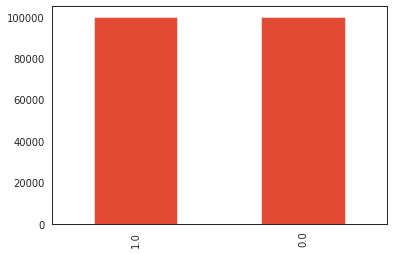

In [0]:
df_sample[target_nm].value_counts().plot(kind='bar') 
plt.show()

### 3-6. 명목형 변수 EDA

#### 3-6-1. 명목형 변수 항목 변환
 - A_성별 --- 성별코드를 '남', '여' 로 변경
 - A_연령대5세단위 --- 연령대코드를 5세 단위 수치로 변경(20~24세는 20으로 표기)
 - A_시도 --- 시도코드를 서울, 경기와 같이 변경
 - A_청력좌, A_청력우 - 청력코드를 정상, 비정상으로 변경
 - A_요단백 - 요단백코드를 정상, 비정상으로 변경
 - A_흡연상태 - 비흡연, 금연, 흡연으로 변경
 - A_음주여부 - 비음주, 음주로 변경

In [0]:
# 성별코드 변환
df_sample["A_성별"] = df_sample["성별코드"].apply(lambda x:  '남' if x == 1 else '여')

# 연령대코드 5세 단위 변환
min_age_code = df_sample["연령대코드5세단위"].min()
print(min_age_code)

df_sample["A_연령대5세단위"] = df_sample["연령대코드5세단위"].apply(lambda x:  (x-1)*5 + 20 if min_age_code == 1 else (x-1)*5).astype(object)

# 시도코드 변환
df_sample["A_시도"] = np.where(df_sample['시도코드'] == 11, '서울', 
                            np.where(df_sample['시도코드']== 26, '부산', 
                              np.where(df_sample['시도코드'] == 27, '대구', 
                                np.where(df_sample['시도코드'] == 28, '인천', 
                                  np.where(df_sample['시도코드'] == 29, '광주', 
                                    np.where(df_sample['시도코드'] == 30, '대전', 
                                      np.where(df_sample['시도코드'] == 31, '울산', 
                                        np.where(df_sample['시도코드'] == 36, '세종', 
                                          np.where(df_sample['시도코드'] == 41, '경기', 
                                            np.where(df_sample['시도코드'] == 42, '강원', 
                                              np.where(df_sample['시도코드'] == 43, '충북', 
                                                np.where(df_sample['시도코드'] == 44, '충남', 
                                                  np.where(df_sample['시도코드'] == 45, '전북', 
                                                    np.where(df_sample['시도코드'] == 46, '전남', 
                                                      np.where(df_sample['시도코드'] == 47, '경북', 
                                                        np.where(df_sample['시도코드'] == 48, '경남', 
                                                          np.where(df_sample['시도코드'] == 49, '제주', '오류')
                                      ))))))))))))))))

# 청력좌  변환
df_sample["A_청력좌"] = df_sample["청력좌"].apply(lambda x:  '정상' if x == 1 else '비정상')

# 청력우  변환
df_sample["A_청력우"] = df_sample["청력우"].apply(lambda x:  '정상' if x == 1 else '비정상')

# 요단백  변환
df_sample["A_요단백"] = df_sample["요단백"].apply(lambda x:  '음성' if x == 1 else '양성')

# 흡연상태  변환
df_sample["A_흡연상태"] = df_sample["흡연상태"].apply(lambda x:  '비흡연' if x == 1 else ('금연' if x==2 else '흡연'))

# 음주여부  변환
df_sample["A_음주여부"] = df_sample["음주여부"].apply(lambda x:  '비음주' if x == 0 else '음주')

1


#### 3-6-1-1 변환 명목형 원 컬럼 삭제
- 변환이전의 코드 형식의 명목형 변수는 필요없으므로 삭제
- 변환이전 코드형식 컬럼 list
- del_obj_trans_cols = ['성별코드', '연령대코드5세단위', '시도코드', '청력좌', '청력우', '요단백', '흡연상태', '음주여부']

In [0]:
# 변환 명목형 원 컬럼 삭제
del_obj_trans_cols = ['성별코드', '연령대코드5세단위', '시도코드', '청력좌', '청력우', '요단백', '흡연상태', '음주여부']
df_sample.drop(columns=del_obj_trans_cols, axis=1, inplace=True)

### 3-6-2. 명목형 변수 추출

In [0]:
# 앞에서 명목형 변수의 형을 object로 모두 변경했기 때문에 컬럼 중에서 object 타입을 가진 컬럼만 뽑아서 명목형 변수의 리스트를 만든다
# 이 때, 데이터의 기본키(인덱스), 종속변수 등을 제외하고 분석하는 것이 좋음

# 단변수 탐색
category_features = [col for col in df_sample.columns if df_sample[col].dtypes == "object"]
print(category_features)

cat_cols = list(set(category_features) - set([target_nm]))
print(cat_cols)

['신장5Cm단위', '체중5Kg단위', '결손치유무', '치석', 'A_성별', 'A_연령대5세단위', 'A_시도', 'A_청력좌', 'A_청력우', 'A_요단백', 'A_흡연상태', 'A_음주여부']
['체중5Kg단위', 'A_성별', 'A_연령대5세단위', 'A_청력좌', 'A_흡연상태', '치석', 'A_청력우', 'A_요단백', '신장5Cm단위', 'A_시도', '결손치유무', 'A_음주여부']


#### 3-6-3. 명목형 변수 count plot (단변량)

findfont: Font family ['/usr/share/fonts/truetype/nanum/NanumGothic.ttf'] not found. Falling back to DejaVu Sans.
findfont: Font family ['/usr/share/fonts/truetype/nanum/NanumGothic.ttf'] not found. Falling back to DejaVu Sans.


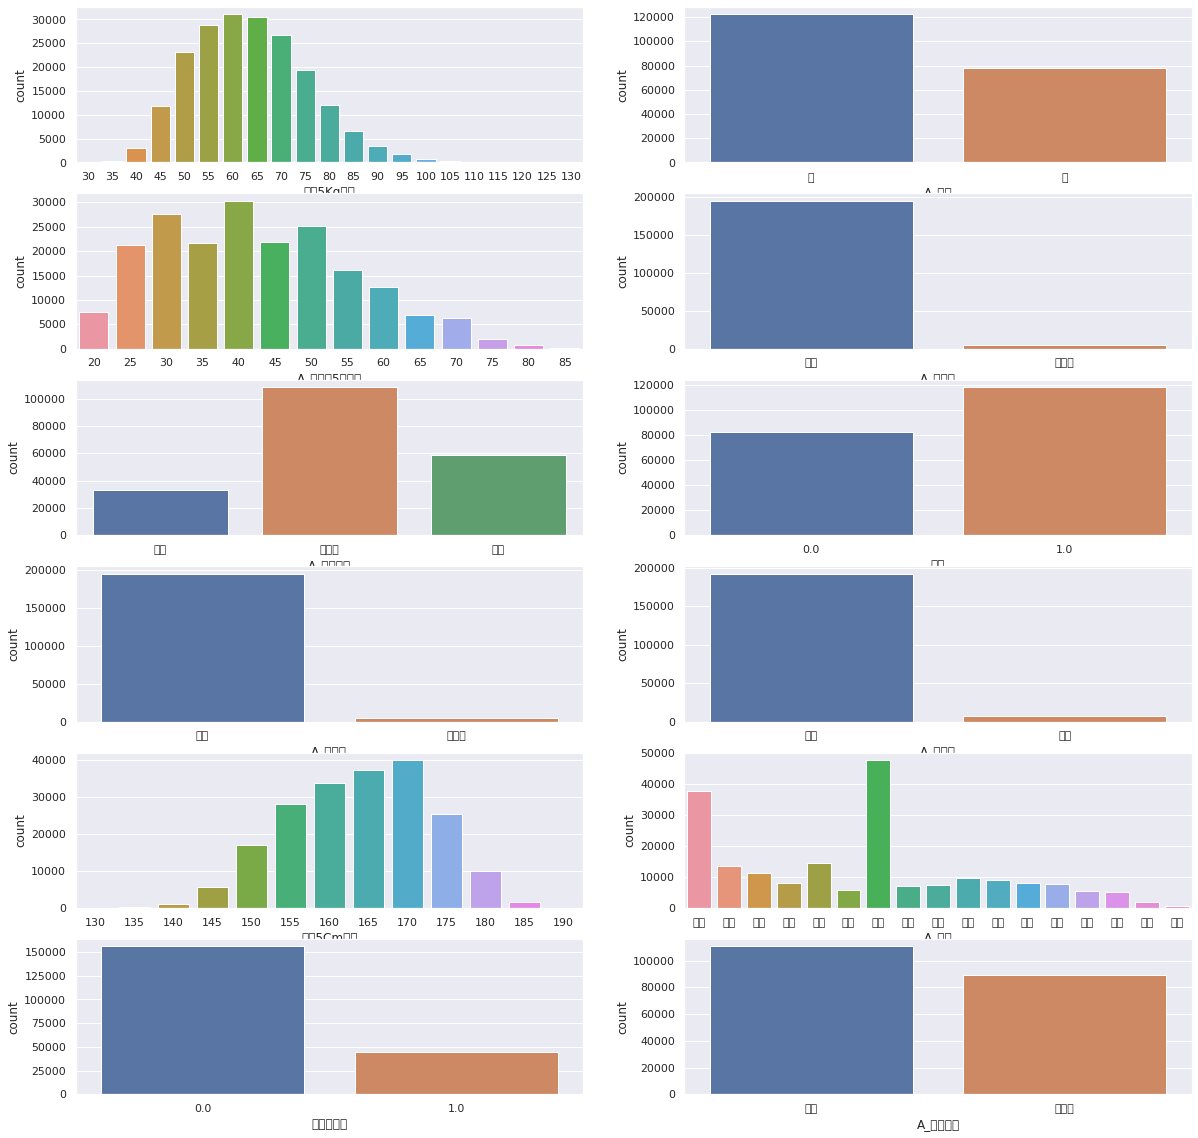

<Figure size 432x288 with 0 Axes>

In [0]:
# 그래프를 통해 명목형 변수의 분포를 체크
fig, saxis = plt.subplots(math.ceil(len(category_features)/2), 2, figsize=(20,20))
plt.figure()

# 변수별로 for문을 돌면서 countplot을 그림
for idx, col in enumerate(cat_cols):
  row_loc = idx // 2
  col_loc = idx % 2
  sns.countplot(x=df_sample[col], data= df_sample, ax = saxis[row_loc,col_loc])
#   df_data[col].value_counts().plot(kind='bar', ax = saxis[row_loc,col_loc])
  
plt.show()

#### 3-6-2. 명목형 변수 bar plot(이변량 - 종속변수와의 관계)

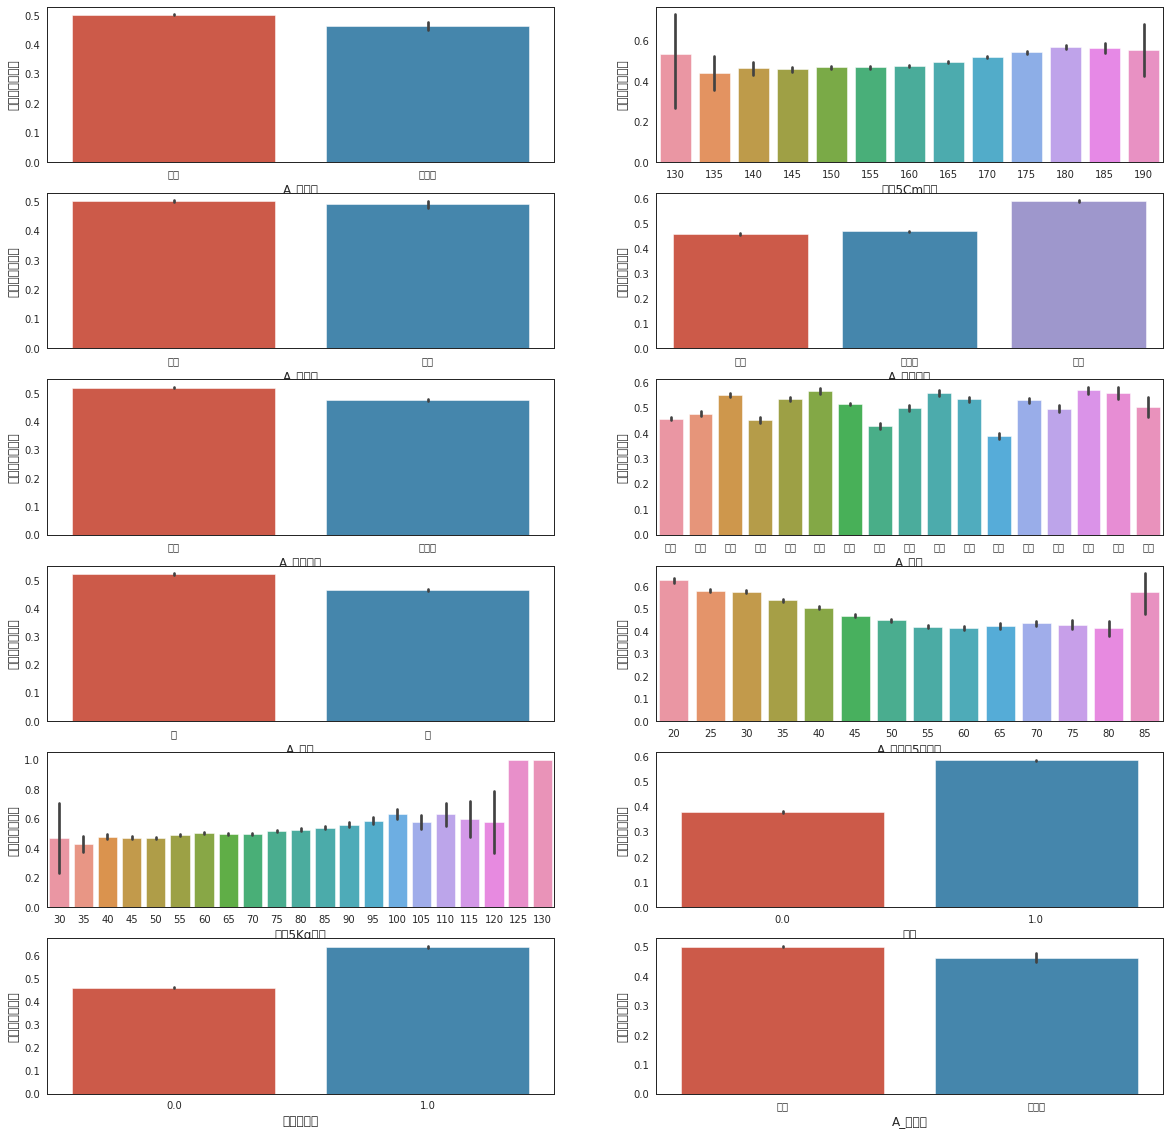

<Figure size 432x288 with 0 Axes>

In [0]:
fig, saxis = plt.subplots(math.ceil(len(category_features)/2), 2, figsize=(20,20))
plt.figure()

# 변수별로 for문을 돌면서 barplot 그림
for idx, col in enumerate(cat_cols):
  row_loc = idx // 2
  col_loc = idx % 2
  sns.barplot(x=col, y=target_nm, data= df_sample, ax = saxis[row_loc,col_loc])
  
plt.show()

### 3-7. 수치형 변수 EDA



#### 3-7-2. 수치형 변수 추출 및 확인
- 구강검진으로 나타날 수 있는 타겟 변수들 중 타겟을 제외하고 삭제 필요
- remove_target_candidates = ['치아마모증유무', '치아우식증유무', '제3대구치사랑니이상', '치석', '결손치유무']
- num_cols = list(set(numeric_features) - set(remove_target_candidates))

In [0]:
# 앞에서 명목형 변수의 형을 object로 모두 변경했기 때문에 컬럼 중에서 object 타입을 가진 컬럼만 뽑아서 명목형 변수의 리스트를 만든다
# 이 때, 데이터의 기본키(인덱스), 종속변수 등을 제외하고 분석하는 것이 좋음

# 단변수 탐색
numeric_features = [col for col in df_sample.columns if df_sample[col].dtypes != "object"]
numeric_features = np.sort(numeric_features)

# 구강검진으로 나타날 수 있는 타겟 변수들 : '치아마모증유무', '치아우식증유무', '제3대구치사랑니이상', '치석', '결손치유무'
remove_target_candidates = ['치아마모증유무', '치아우식증유무', '제3대구치사랑니이상', '치석', '결손치유무']

not_remove_in_tg = ['치석','결손치유무']

num_cols = list(set(numeric_features) - set(remove_target_candidates))
print(num_cols)

print(len(num_cols)) # 총 15개

['혈청지오티ALT', '트리글리세라이드', '허리둘레', '혈청지오티AST', '시력우', '혈청크레아티닌', '식전혈당공복혈당', '시력좌', '혈색소', '감마지티피', 'LDL콜레스테롤', '수축기혈압', 'HDL콜레스테롤', '총콜레스테롤', '이완기혈압']
15


#### 3-7-3. 수치형 변수 count plot (단변량)

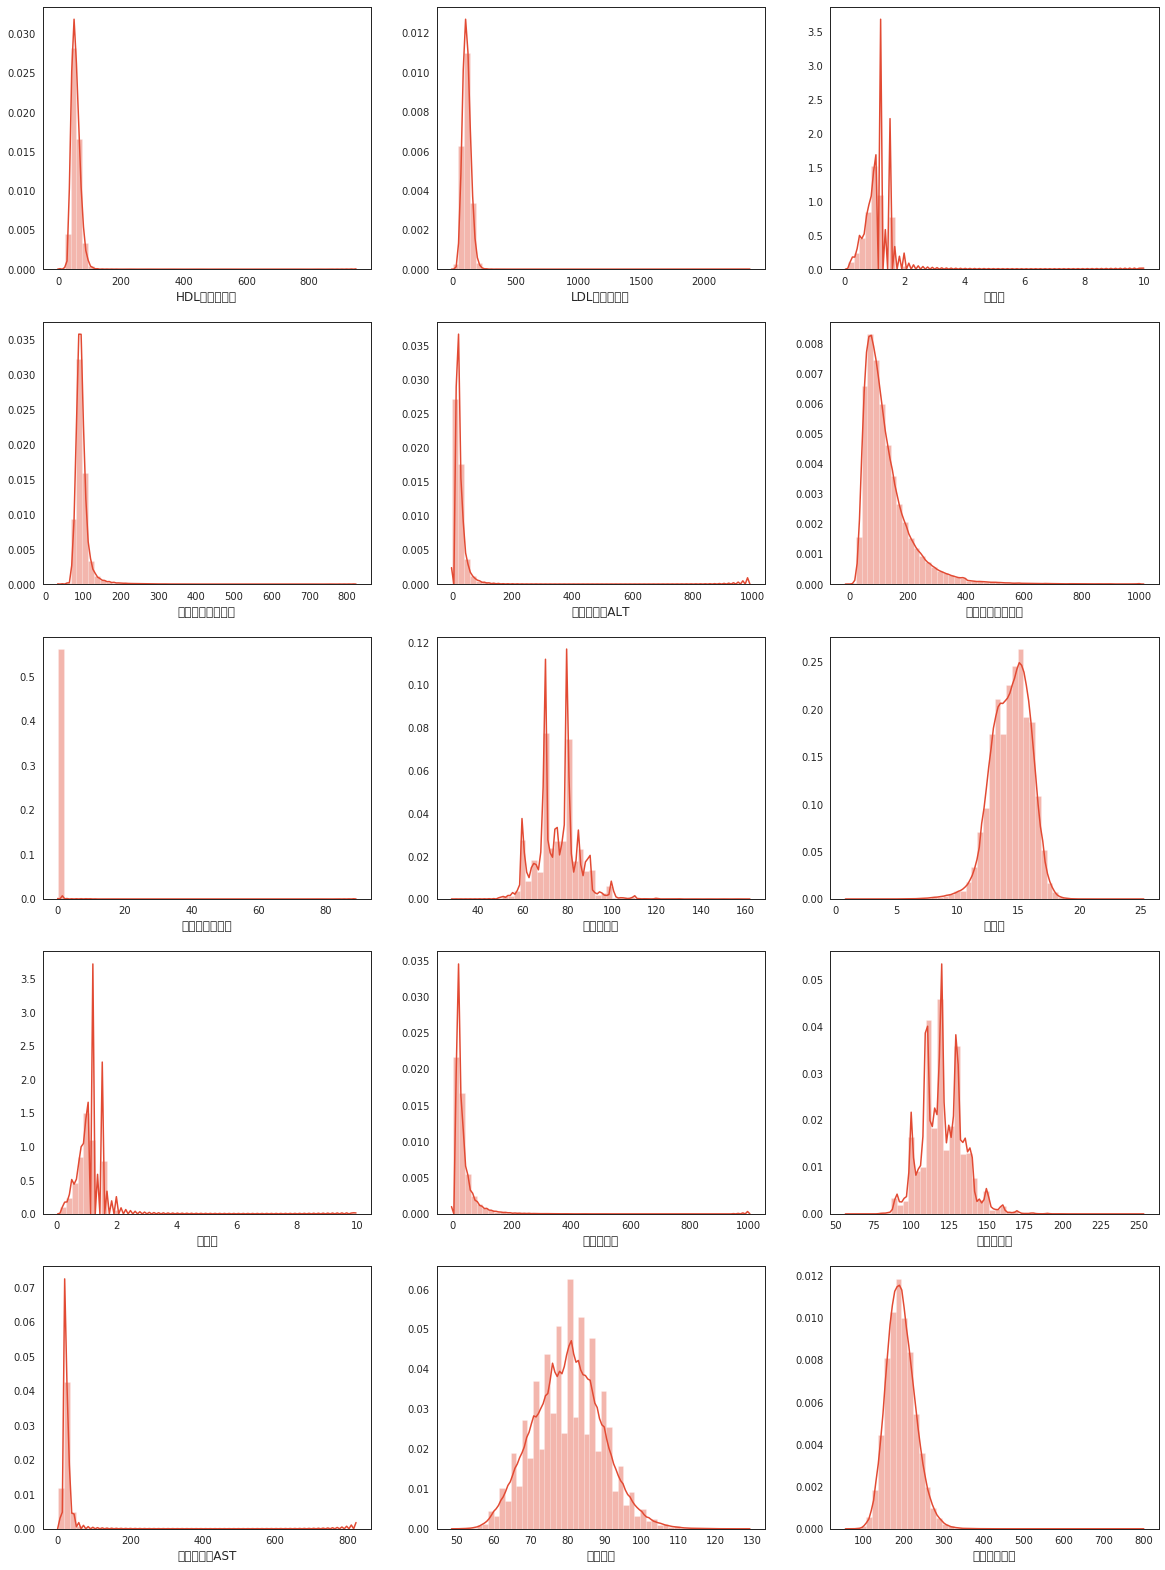

<Figure size 432x288 with 0 Axes>

In [0]:
# 단변수 탐색 - 단변수 탐색은 seaborn 패키지의 distplot 함수를 이용하면 편함
# 수치형 변수만 골라냄
fig, saxis = plt.subplots(math.ceil(len(num_cols)/3), 3, figsize=(20,28))
plt.figure()

# 변수별로 for문을 돌면서 distplot을 그림
for idx, col in enumerate(num_cols):
    row_loc = idx // 3
    col_loc = idx % 3
    sns.distplot(df_sample.loc[df_sample[col].notnull(), col], ax = saxis[row_loc,col_loc])

plt.show()

#### 3-7-4. 수치형 변수 Transformations 
 - num_ln_target_features --- 로그를 취할 변수명 list(추후 최종 입력 전 삭제 필요)

 - num_ln_cols --- 로그를 취하고 난 뒤의 변수명 list

In [0]:
# 수치형 변수들에 log를 취한 값 산출
# 로그 취할 대상 컬럼 선정 # 그리고 log를 취한 원 변수는 추후에 버릴 예정으로 따로 기록해 둔다
num_ln_target_features = ['LDL콜레스테롤', 'HDL콜레스테롤', '시력좌', '시력우', '혈청크레아티닌', '혈청지오티AST','혈청지오티ALT', '감마지티피', '트리글리세라이드', '식전혈당공복혈당']

# Feature Engineering의 일환으로 Log 값 취한 뒤 Normalization을 하여 변수명 + LN (lognorm)으로 열 추가 후 그래프 다시 그림
num_ln_cols = list(map(lambda x: "LN_"+str(x), num_ln_target_features))

num_pipeline = Pipeline([
        ('log_scaler', FunctionTransformer(np.log1p, validate=True)), # pipeline 내 log transformation을 위해 Function Transfomer 사용
        ('normalizer', MinMaxScaler()),
    ])

piped_np = num_pipeline.fit_transform(df_sample[num_ln_target_features])
piped_df = pd.DataFrame(piped_np, columns=num_ln_cols)

print(len(piped_df))
piped_df.head()

300000


,LN_LDL콜레스테롤,LN_HDL콜레스테롤,LN_시력좌,LN_시력우,LN_혈청크레아티닌,LN_혈청지오티AST,LN_혈청지오티ALT,LN_감마지티피,LN_트리글리세라이드,LN_식전혈당공복혈당
0,0.518038,0.590503,0.260671,0.189809,0.135733,0.334712,0.313626,0.493684,0.665395,0.354140
1,0.518038,0.528899,0.260671,0.238306,0.124088,0.426085,0.456634,0.707116,0.766287,0.359953
2,0.628203,0.473652,0.214731,0.260671,0.124088,0.373981,0.335147,0.469502,0.709090,0.339129
3,0.598714,0.501780,0.302229,0.302229,0.135733,0.398334,0.430997,0.362258,0.671706,0.357060
4,0.523374,0.464632,0.214731,0.214731,0.124088,0.465689,0.482828,0.370512,0.597555,0.336041


#### 3-7-6. 수치형 LN 변수 count plot (단변량)

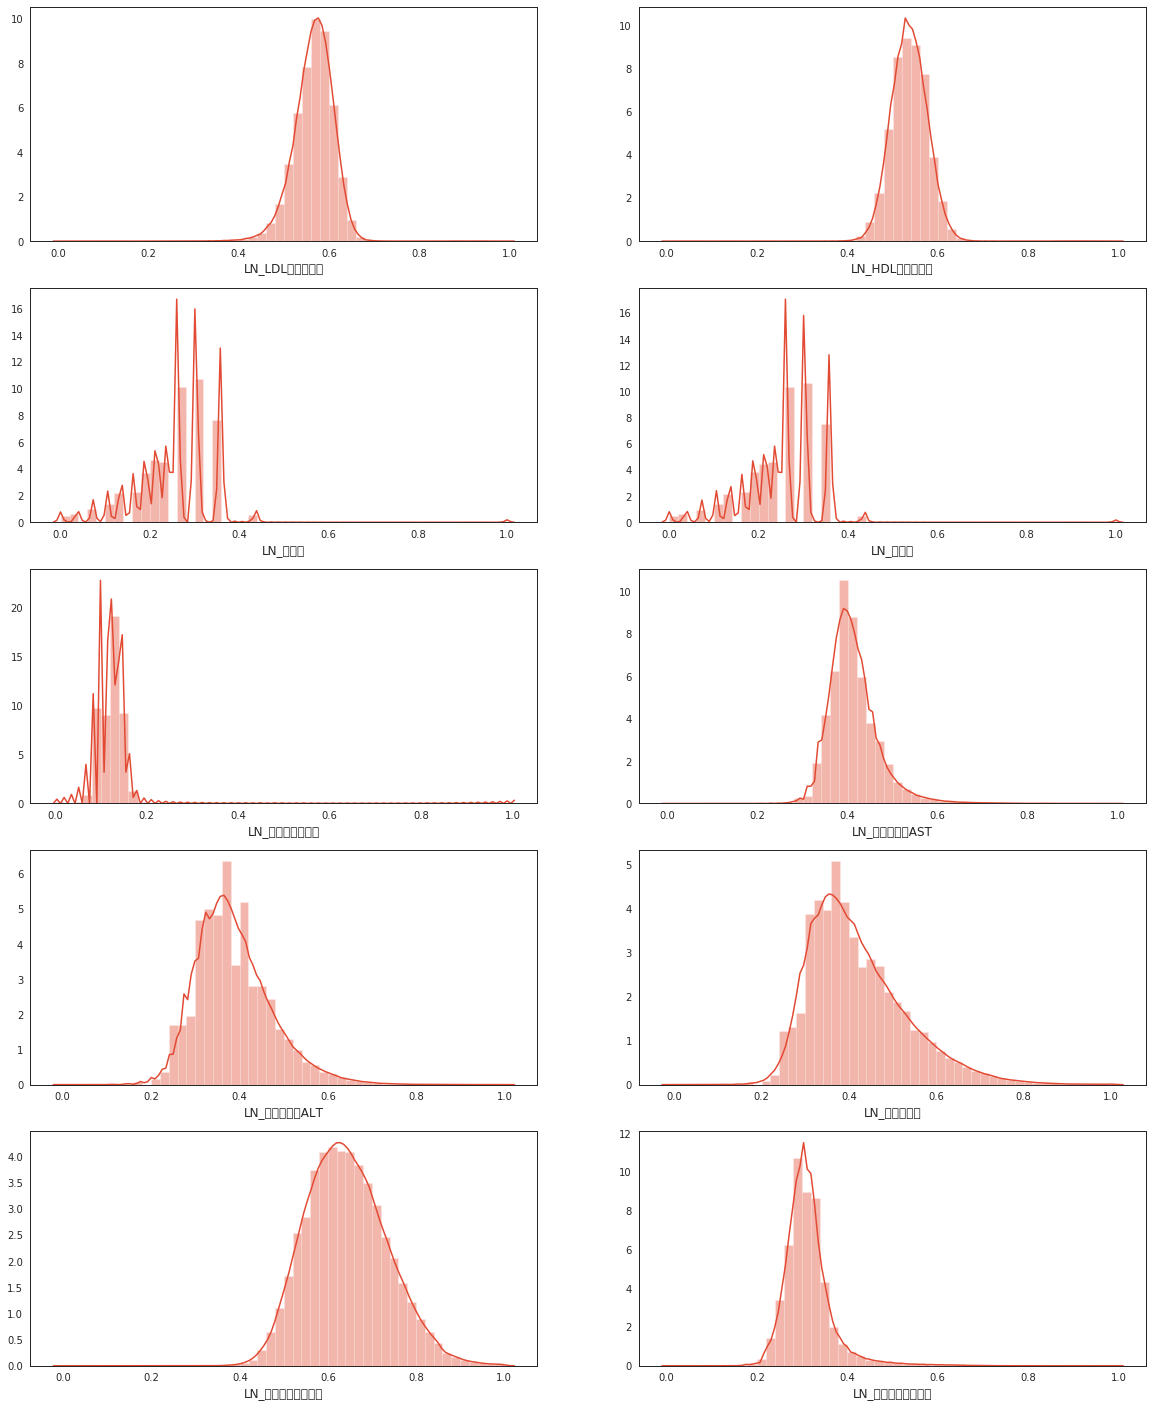

<Figure size 432x288 with 0 Axes>

In [0]:
# 단변수 탐색 with log 변형 변수
fig, saxis = plt.subplots(math.ceil(len(num_ln_cols)/2), 2, figsize=(20,25))
plt.figure()

# 변수별로 for문을 돌면서 distplot 그림
for idx, col in enumerate(num_ln_cols):
    row_loc = idx // 2
    col_loc = idx % 2
    # print(idx, row_loc, col_loc)
    sns.distplot(piped_df.loc[piped_df[col].notnull(), col], ax = saxis[row_loc,col_loc])

plt.show()

#### 3-7-5. 로그 취한 수치형 변수 Concat을 통한 새 Dataframe 생성 

In [0]:
print("Before Re-indexing: Data count is ", len(df_sample))
df_sample.drop_duplicates()
df_sample.reset_index(inplace=True, drop=True)
print("After Re-indexing: Data count is ", len(df_sample))

df_fe = pd.concat([df_sample, piped_df], axis=1)
df_fe.head()

Before Re-indexing: Data count is  300000
After Re-indexing: Data count is  300000


,신장5Cm단위,체중5Kg단위,허리둘레,시력좌,시력우,수축기혈압,이완기혈압,식전혈당공복혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,혈청크레아티닌,혈청지오티AST,혈청지오티ALT,감마지티피,치아우식증유무,결손치유무,치아마모증유무,제3대구치사랑니이상,치석,A_성별,A_연령대5세단위,A_시도,A_청력좌,A_청력우,A_요단백,A_흡연상태,A_음주여부,LN_LDL콜레스테롤,LN_HDL콜레스테롤,LN_시력좌,LN_시력우,LN_혈청크레아티닌,LN_혈청지오티AST,LN_혈청지오티ALT,LN_감마지티피,LN_트리글리세라이드,LN_식전혈당공복혈당
0,170,70,79,1.0,0.7,125,80,108,177,124,75,77.0,13.6,1.0,14,13,42,0.0,0,0.0,0.0,0,남,60,서울,정상,정상,음성,금연,음주,0.518038,0.590503,0.260671,0.189809,0.135733,0.334712,0.313626,0.493684,0.665395,0.354140
1,170,75,88,1.0,0.9,130,88,110,175,233,51,77.0,15.1,0.9,25,33,161,0.0,1,1.0,0.0,1,남,50,서울,정상,정상,음성,금연,음주,0.518038,0.528899,0.260671,0.238306,0.124088,0.426085,0.456634,0.707116,0.766287,0.359953
2,160,60,76,0.8,1.0,115,88,103,238,163,36,169.0,12.0,0.9,18,15,36,0.0,0,0.0,0.0,0,여,45,인천,정상,정상,음성,비흡연,비음주,0.628203,0.473652,0.214731,0.260671,0.124088,0.373981,0.335147,0.469502,0.709090,0.339129
3,175,75,83,1.2,1.2,118,78,109,206,129,43,137.0,17.2,1.0,21,28,18,0.0,0,0.0,0.0,1,남,45,경남,정상,정상,음성,금연,비음주,0.598714,0.501780,0.302229,0.302229,0.135733,0.398334,0.430997,0.362258,0.671706,0.357060
4,165,55,78,0.8,0.8,135,85,102,130,81,34,80.0,14.7,0.9,32,39,19,0.0,0,0.0,0.0,0,남,50,전북,정상,정상,음성,비흡연,비음주,0.523374,0.464632,0.214731,0.214731,0.124088,0.465689,0.482828,0.370512,0.597555,0.336041


In [0]:
import gc
gc.collect()

158

### 3-8. Information Value 계산을 위한 환경 세팅

### 3-8-1. woe library 설치

In [0]:
# woe package install
! pip install woe

### 3-8-2. Library Load 및 환경 변수 세팅

In [0]:
# Calculate IV Setting
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import string
import woe
from woe.eval import plot_ks

max_bin = 20
force_bin = 3

### 3-8-3. Information Value 산출 사용자 정의 함수 정의

In [0]:
# Define a binning function for continous independent variables
def mono_bin(Y, X, n = max_bin):
  df1 = pd.DataFrame({"X": X, "Y": Y})
  justmiss = df1[['X','Y']][df1.X.isnull()]
  notmiss = df1[['X','Y']][df1.X.notnull()]
  r = 0
  while np.abs(r) < 1:
    try:
      global d1
      global d2
      d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
      d2 = d1.groupby('Bucket', as_index=True)
      r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
      n = n - 1 
    except Exception as e:
      n = n - 1
      break
      
  if len(d2) == 1:
    n = force_bin         
    bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
    if len(np.unique(bins)) == 2:
        bins = np.insert(bins, 0, 1)
        bins[1] = bins[1]-(bins[1]/2)
    d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
    d2 = d1.groupby('Bucket', as_index=True)

  d3 = pd.DataFrame({},index=[])
  d3["MIN_VALUE"] = d2.min().X
  d3["MAX_VALUE"] = d2.max().X
  d3["COUNT"] = d2.count().Y
  d3["EVENT"] = d2.sum().Y
  d3["NONEVENT"] = d2.count().Y - d2.sum().Y
  d3=d3.reset_index(drop=True)

  if len(justmiss.index) > 0:
      d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
      d4["MAX_VALUE"] = np.nan
      d4["COUNT"] = justmiss.count().Y
      d4["EVENT"] = justmiss.sum().Y
      d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
      d3 = d3.append(d4,ignore_index=True)

  d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
  d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
  d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
  d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
  d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["VAR_NAME"] = "VAR"
  d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
  d3 = d3.replace([np.inf, -np.inf], 0)
  d3.IV = d3.IV.sum()

  return(d3)
  
# Define a binning function for categorical independent variables
def char_bin(Y, X):
  df1 = pd.DataFrame({"X": X, "Y": Y})
  justmiss = df1[['X','Y']][df1.X.isnull()]
  notmiss = df1[['X','Y']][df1.X.notnull()]    
  df2 = notmiss.groupby('X',as_index=True)

  d3 = pd.DataFrame({},index=[])
  d3["COUNT"] = df2.count().Y
  d3["MIN_VALUE"] = df2.sum().Y.index
  d3["MAX_VALUE"] = d3["MIN_VALUE"]
  d3["EVENT"] = df2.sum().Y
  d3["NONEVENT"] = df2.count().Y - df2.sum().Y

  if len(justmiss.index) > 0:
    d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
    d4["MAX_VALUE"] = np.nan
    d4["COUNT"] = justmiss.count().Y
    d4["EVENT"] = justmiss.sum().Y
    d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
    d3 = d3.append(d4,ignore_index=True)

  d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
  d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
  d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
  d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
  d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["VAR_NAME"] = "VAR"
  d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
  d3 = d3.replace([np.inf, -np.inf], 0)
  d3.IV = d3.IV.sum()
  d3 = d3.reset_index(drop=True)

  return(d3)

# Calculate Information Values
def calc_iv_all(df1, target):
    
  stack = traceback.extract_stack()
  filename, lineno, function_name, code = stack[-2]
  vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
  final = (re.findall(r"[\w']+", vars_name))[-1]

  x = df1.dtypes.index
  count = -1

  for i in tqdm_notebook(x):
    if i.upper() not in (final.upper()):
      if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
        conv = mono_bin(target, df1[i])
        conv["VAR_NAME"] = i
        count = count + 1
      else:
        conv = char_bin(target, df1[i])
        conv["VAR_NAME"] = i            
        count = count + 1

      if count == 0:
        iv_df = conv
      else:
        iv_df = iv_df.append(conv,ignore_index=True)

  iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
  iv = iv.reset_index()
  return(iv_df,iv)

### 3-8-4. IV 산출을 위한 data sampling 및 IV 산출

In [0]:
# Information Value Test를 위한 임시 Dataframe 생성
need_cols = list(set(df_fe.columns) - (set(num_ln_target_features + remove_target_candidates) - set([target_nm] + not_remove_in_tg)))

df_iv_test = df_fe[need_cols].copy()

In [0]:
# IV 산출
first_iv_df, IV_first = calc_iv_all(df_iv_test,df_iv_test[target_nm])
# first_iv_df

# IV 값 내림차순 정렬
IV_first.sort_values('IV',ascending=False)

,VAR_NAME,IV
24,치석,0.164486
18,결손치유무,0.087619
2,A_연령대5세단위,0.064437
7,A_흡연상태,0.051592
1,A_시도,0.030950
20,신장5Cm단위,0.014995
0,A_성별,0.012325
22,체중5Kg단위,0.008519
11,LN_시력우,0.008455
27,혈색소,0.008455


## 4. Feature Engineering

### 4-1. Feature Engineering 내부 변수 추가
- 데이터셋 내 내부 변수의 범주화를 통한 신규 변수 추출

In [0]:
# 기존 수치형 변수들을 LN 변수들로 치환
# df_fe.drop(columns=numeric_feature, axis=1, inplace=True)

# BMI 변수 추가
df_fe["A_BMI"] = (df_fe["체중5Kg단위"]/(df_fe["신장5Cm단위"]*df_fe["신장5Cm단위"])).astype(float)

# 공복 혈당 
# 100 이하는 정상/ 100 ~ 125는 '공복혈당장애 - 당뇨 전단계'/ 125 이상은 당뇨
# 당뇨병의 중간인 100~125 mg/dL가 나오거나 

df_fe["A_diabetes"] = np.where(df_fe['식전혈당공복혈당'].between(0, 100, inclusive=True), '정상', 
                               np.where(df_fe['식전혈당공복혈당'].between(100, 124.9, inclusive=True), '당뇨전단계', 
                                        '당뇨')
                              )

# HDL 콜레스테롤
# HDL 콜레스테롤 수치가 남자에서 40 mg/dL (1.0 mmol/L) 이하 또는 여자에서 50 mg/dL (1.3 mmol/L) 이하일 경우에는 다른 위험인자와 독립적으로 심장 질환의 위험도가 증가
# HDL 콜레스테롤 수치가 남자에서 40-50 mg/dL (1.0-1.3 mmol/L) 그리고 여자에서 50-59 mg/dL (1.3-1.5 mmol/L)인 경우에는 심장 질환의 평균위험도와 연관
# 보통 HDL 콜레스테롤 수치가 60 mg/dL (1.55 mmol/L) 또는 그 이상일 경우에는 심장 질환 평균 위험도보다 낮음
# National Cholesterol Education Panel Adult Treatment Guidelines에 따르면 HDL 콜레스테롤 수치가 60 mg/dL 이상일 경우 심장 질환에서 보호되고 음성 위험 인자로서 치료되어야 함
df_fe["A_HDL"] = np.where(
                    (df_fe['A_성별'] == "여") & (df_fe['HDL콜레스테롤']<= 50), '고위험', 
                       np.where(
                         (df_fe['A_성별']== "여") & (df_fe['HDL콜레스테롤'].between(50, 59.9, inclusive=True)), '위험', 
                           np.where(
                               (df_fe['A_성별']== "남") & (df_fe['HDL콜레스테롤']<= 40), '고위험', 
                                      np.where(
                                          (df_fe['A_성별']== "남") & (df_fe['HDL콜레스테롤'].between(40, 49.9, inclusive=True)), '위험', '정상')
                          )))
# LDL 콜레스테롤(혈중 모든 콜레스테롤 중 LDL 콜레스테롤이 심장질환에 대한 위험도를 확인하는데 가장 중요한 지표)
# 대부분의 치료 결정이 LDL 수치를 토대로 이루어지기 때문에 이 검사를 통해 식이요법 또는 운동처방의 효과를 감시하거나 지질감소 약물을 처방하는 것이 유용한지에 대한 평가
# 100 mg/dL (2.59mmol/L) 미만 – 최적
# 100-129 mg/dL (2.59-3.34 mmol/L) – 최적에 인접
# 130-159 mg/dL (3.37-4.12 mmol/L) – 상한 경계성
# 160-189 mg/dL (4.15-4.90 mmol/L) – 높음
# 190 mg/dL (4.90 mmol) 이상 – 매우 높음
df_fe["A_LDL"] = np.where(df_fe['LDL콜레스테롤']<100, '최적', 
                    np.where(df_fe['LDL콜레스테롤'].between(100, 122.9, inclusive=True), '최적인접', 
                             np.where(df_fe['LDL콜레스테롤'].between(130, 159.9, inclusive=True), '상한경계', 
                                      np.where(df_fe['LDL콜레스테롤'].between(160, 189.9, inclusive=True), '높음', '매우높음')
                              )))

# 트리글리세라이드
# 지방의 한 형태로서 몸의 주요 에너지원, 트리글리세라이드가 증가하는 것은, 이유가 분명하지 않으나 심혈관 질환으로 진행될 위험의 증가와 관련
# 일부 인자들 즉, 운동 부족, 과체중, 흡연, 과음 및 당뇨와 신질환 등의 질병 상태가 고트리글리세라이드혈증 및 심혈관 질환 위험도 증가에 기여할 수 있음
# 성인에서는 트리글리세라이드 결과가 아래와 같이 나뉘어진다.
# 150 mg/dL (1.7 mmol/L) 미만: 바람직
# 150-199 mg/dL (1.7-2.2 mmol/L): 경계성증가
# 200-499 mg/dL (2.3-5.6 mmol/L): 증가: 
# 500 mg/dL (5.6 mmol/L) 이상: 매우 증가
# 이 수치는 공복시 트리글리세라이드 수치에 기준합니다.
df_fe["A_TRI"] = np.where(df_fe['트리글리세라이드']<150, '바람직', 
                    np.where(df_fe['트리글리세라이드'].between(150, 199.9, inclusive=True), '경계성증가', 
                             np.where(df_fe['트리글리세라이드'].between(200, 499.9, inclusive=True), '증가', '매우증가')
                              ))

# 혈색소
# 성인의 데시리터(100밀리리터) 당 12그램에서 18그램 정도: 정상치
# 18그램 이상: 폐질환 등 기타 이상
# 12그램 미만: 빈혈
df_fe["A_HEMO"] = np.where(df_fe['혈색소'].between(12, 17.9, inclusive=True), '정상', 
                    np.where(df_fe['혈색소']>=18, '이상', '빈혈'))

# 요단백: 소변으로 빠져나가는 잉여의 단백질을 검출하기 위해, 신장 기증을 평가하고 모니터하는 것을 돕기 위해,  그리고 신장 손상을 검출하기 위해 검사
# 요단백은 보통 소변에서 검출 되지 않음

# 혈중 크레아티닌 농도의 
# 정상범위는 0.50~1.4 mg/dL 입니다
# 근육량에 비례하는 검사결과이므로 여성보다는 남성에게서 약간 높은 수치가 나타나고, 식사나 운동이 결과에 영향이 거의 미치지 않습니다. 지속적으로 많은 양의 육식을 섭취한 경우에는 크레아티닌 농도가 높게 측정됩니다.
df_fe["A_CRE"] = np.where(df_fe['혈청크레아티닌'].between(0.5, 1.4, inclusive=True), '정상', '이상')

# 혈청지오티AST:
#  간기능을 평가하는 기초검사항목으로서 알코올성 간장애나 만성 간질환에서 주로 증가한다.
 

# 혈청지오티ALT:
# 간기능을 평가하는 기초검사항목으로서 급성 간염 시 주로 증가한다.
# 증가: 간질환, 심근경색, 지방간, 비만


# 감마지티피
# 간장세포나 담낭세포가 파괴되면 감마지티피가 혈액속으로 누출되어 수치가 높아짐
# 남자는 50IU 이하, 여자는 32IU이하가 정상
# 100이하면 음주 조절을 통해 조정 가능하나 100 이상이면 지방간이 진행되고 있을 가능성이 높음
# 200 이상이면 담석이나 담도암등으로 담도가 막혀있을 가능성이 높음
# 500 이상이면 황달
df_fe["A_GTP"] = np.where((df_fe['감마지티피'] >= 500), '황달', 
                       np.where(df_fe['감마지티피']>=200, '담도이상', 
                           np.where(df_fe['감마지티피']>= 100, '이상가능', 
                             np.where((df_fe['A_성별']== "남") & (df_fe['감마지티피']<=50), '정상',
                              np.where((df_fe['A_성별']== "여") & (df_fe['감마지티피']<=32), '정상', '체크')
                          ))))

In [0]:
df_fe.head(2)

,신장5Cm단위,체중5Kg단위,허리둘레,시력좌,시력우,수축기혈압,이완기혈압,식전혈당공복혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,혈청크레아티닌,혈청지오티AST,혈청지오티ALT,감마지티피,치아우식증유무,결손치유무,치아마모증유무,제3대구치사랑니이상,치석,A_성별,A_연령대5세단위,A_시도,A_청력좌,A_청력우,A_요단백,A_흡연상태,A_음주여부,LN_LDL콜레스테롤,LN_HDL콜레스테롤,LN_시력좌,LN_시력우,LN_혈청크레아티닌,LN_혈청지오티AST,LN_혈청지오티ALT,LN_감마지티피,LN_트리글리세라이드,LN_식전혈당공복혈당,A_BMI,A_diabetes,A_HDL,A_LDL,A_TRI,A_HEMO,A_CRE,A_GTP
0,170,70,79,1.0,0.7,125,80,108,177,124,75,77.0,13.6,1.0,14,13,42,0.0,0,0.0,0.0,0,남,60,서울,정상,정상,음성,금연,음주,0.518038,0.590503,0.260671,0.189809,0.135733,0.334712,0.313626,0.493684,0.665395,0.354140,0.002422,당뇨전단계,정상,최적,바람직,정상,정상,정상
1,170,75,88,1.0,0.9,130,88,110,175,233,51,77.0,15.1,0.9,25,33,161,0.0,1,1.0,0.0,1,남,50,서울,정상,정상,음성,금연,음주,0.518038,0.528899,0.260671,0.238306,0.124088,0.426085,0.456634,0.707116,0.766287,0.359953,0.002595,당뇨전단계,정상,최적,증가,정상,정상,이상가능


### 4-2. Feature Engineering 외부 변수 추가
- 외부 데이터 및 변수를 통한 신규 변수 추출

### 4-2-1. 데이터셋 외부 변수 load 및 검증

In [0]:
!ls /gdrive/My\ Drive/

'Getting started.pdf'   sds


In [0]:
# df_add1 = pd.read_csv('../gdrive/My Drive/sds/data/완료_구강검진결과_14년도_교육이후개별비.csv', encoding = 'euc-kr')
# # df_add1["성별"] = df_add1["성별"].str[:1]
# # df_add1.drop(columns=['n_기타_결과'], axis=1, inplace=True)
df_add1 = pd.read_csv('../gdrive/My Drive/sds/data/완료_구강검진결과_14년도_총수검인원기준비.csv', encoding = 'euc-kr')
df_add2 = pd.read_csv('../gdrive/My Drive/sds/data/완료_KOSIS 연령별 성별 치과 평균 수진횟수 2012.csv', encoding = 'euc-kr')
df_add3 = pd.read_csv('../gdrive/My Drive/sds/data/완료_KOSIS 치주질환 유병률 추이_2012.csv', encoding = 'euc-kr')

display(df_add1.info())
display(df_add2.info())
display(df_add3.info())
display(df_add1.head())
display(df_add2.head())
display(df_add3.head())

# KOSIS 연령별 성별 치과 평균 수진횟수 2014

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 13 columns):
시도             34 non-null object
성별             34 non-null object
n_정상A_결과       34 non-null float64
n_정상B_결과       34 non-null float64
n_주의_결과        34 non-null float64
n_치료필요_결과      34 non-null float64
n_영양_교육        34 non-null float64
n_위생_교육        34 non-null float64
n_불소_교육        34 non-null float64
n_정밀검진_권고      34 non-null float64
n_관리_권고        34 non-null float64
n_우식필요_권고      34 non-null float64
n_치주치료필요_권고    34 non-null float64
dtypes: float64(11), object(2)
memory usage: 3.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 4 columns):
연령              28 non-null int64
성별              28 non-null object
n_치과병원평균수진횟수    28 non-null float64
n_치과의원평균수진횟수    28 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
성별             28 non-null object
연령             28 non-null int64
n_치주질환유병률추이    28 non-null int64
dtypes: int64(2), object(1)
memory usage: 800.0+ bytes


None

,시도,성별,n_정상A_결과,n_정상B_결과,n_주의_결과,n_치료필요_결과,n_영양_교육,n_위생_교육,n_불소_교육,n_정밀검진_권고,n_관리_권고,n_우식필요_권고,n_치주치료필요_권고
0,서울,남,0.55,2.11,3.50,4.16,2.79,9.67,7.05,0.61,9.32,3.80,0.92
1,서울,여,0.51,2.48,2.99,2.97,2.21,8.10,5.95,0.49,8.17,2.68,0.57
2,부산,남,0.17,0.74,1.02,1.88,0.97,3.47,2.56,0.20,3.45,1.75,0.40
3,부산,여,0.15,0.79,0.78,1.23,0.57,2.62,1.88,0.14,2.72,1.12,0.22
4,대구,남,0.09,0.43,0.64,0.74,0.50,1.79,1.32,0.09,1.73,0.69,0.14


,연령,성별,n_치과병원평균수진횟수,n_치과의원평균수진횟수
0,20,남,60.71,712.21
1,20,여,102.84,1036.57
2,25,남,63.40,751.73
3,25,여,87.14,894.88
4,30,남,53.34,714.44


,성별,연령,n_치주질환유병률추이
0,남,20,126
1,남,25,126
2,남,30,196
3,남,35,196
4,남,40,201


### 4-2-2. 데이터셋 외부 변수 결합


In [0]:
# Multiple Key를 사용하여 Join
# left_on=['column_name1','column_name2'], right_on = ['column_name3','column_name4']
print(len(df_fe))

df_new = pd.merge(left=df_fe, right=df_add1, how='outer', left_on=['A_시도','A_성별'], right_on = ['시도','성별'], sort=False)
df_new.drop(columns=['시도','성별'], axis=1, inplace=True)
display(df_new.head())
print(len(df_new))

df_new = pd.merge(left=df_new, right=df_add2, how='outer', left_on=['A_연령대5세단위','A_성별'], right_on = ['연령','성별'], sort=False)
df_new.drop(columns=['연령','성별'], axis=1, inplace=True)
display(df_new.head())
print(len(df_new))

df_new = pd.merge(left=df_new, right=df_add3, how='outer', left_on=['A_연령대5세단위','A_성별'], right_on = ['연령','성별'], sort=False)
df_new.drop(columns=['연령','성별'], axis=1, inplace=True)
display(df_new.head())
print(len(df_new))

display(df_new.info())

300000


,신장5Cm단위,체중5Kg단위,허리둘레,시력좌,시력우,수축기혈압,이완기혈압,식전혈당공복혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,혈청크레아티닌,혈청지오티AST,혈청지오티ALT,감마지티피,치아우식증유무,결손치유무,치아마모증유무,제3대구치사랑니이상,치석,A_성별,A_연령대5세단위,A_시도,A_청력좌,A_청력우,A_요단백,A_흡연상태,A_음주여부,LN_LDL콜레스테롤,LN_HDL콜레스테롤,LN_시력좌,LN_시력우,LN_혈청크레아티닌,LN_혈청지오티AST,LN_혈청지오티ALT,LN_감마지티피,LN_트리글리세라이드,LN_식전혈당공복혈당,A_BMI,A_diabetes,A_HDL,A_LDL,A_TRI,A_HEMO,A_CRE,A_GTP,n_정상A_결과,n_정상B_결과,n_주의_결과,n_치료필요_결과,n_영양_교육,n_위생_교육,n_불소_교육,n_정밀검진_권고,n_관리_권고,n_우식필요_권고,n_치주치료필요_권고
0,170,70,79,1.0,0.7,125,80,108,177,124,75,77.0,13.6,1.0,14,13,42,0.0,0,0.0,0.0,0,남,60,서울,정상,정상,음성,금연,음주,0.518038,0.590503,0.260671,0.189809,0.135733,0.334712,0.313626,0.493684,0.665395,0.354140,0.002422,당뇨전단계,정상,최적,바람직,정상,정상,정상,0.55,2.11,3.5,4.16,2.79,9.67,7.05,0.61,9.32,3.8,0.92
1,170,75,88,1.0,0.9,130,88,110,175,233,51,77.0,15.1,0.9,25,33,161,0.0,1,1.0,0.0,1,남,50,서울,정상,정상,음성,금연,음주,0.518038,0.528899,0.260671,0.238306,0.124088,0.426085,0.456634,0.707116,0.766287,0.359953,0.002595,당뇨전단계,정상,최적,증가,정상,정상,이상가능,0.55,2.11,3.5,4.16,2.79,9.67,7.05,0.61,9.32,3.8,0.92
2,175,60,78,1.0,1.2,138,88,104,207,64,80,114.0,14.9,0.9,15,10,20,0.0,0,0.0,0.0,1,남,25,서울,정상,정상,음성,비흡연,음주,0.572934,0.600846,0.260671,0.302229,0.124088,0.345433,0.274757,0.378363,0.560170,0.342189,0.001959,당뇨전단계,정상,최적인접,바람직,정상,정상,정상,0.55,2.11,3.5,4.16,2.79,9.67,7.05,0.61,9.32,3.8,0.92
3,170,70,86,1.5,1.0,130,80,91,240,133,45,168.0,16.3,0.8,23,20,17,0.0,0,0.0,0.0,1,남,55,서울,비정상,비정상,음성,흡연,비음주,0.627369,0.508996,0.357967,0.260671,0.111812,0.412788,0.378975,0.353558,0.676582,0.299937,0.002422,정상,위험,높음,바람직,정상,정상,정상,0.55,2.11,3.5,4.16,2.79,9.67,7.05,0.61,9.32,3.8,0.92
4,160,55,75,1.5,1.5,120,64,92,180,96,69,92.0,14.7,0.9,18,16,17,0.0,0,0.0,0.0,0,남,40,서울,정상,정상,음성,금연,음주,0.542909,0.577153,0.357967,0.357967,0.124088,0.373981,0.344918,0.353558,0.624587,0.303393,0.002148,정상,정상,최적,바람직,정상,정상,정상,0.55,2.11,3.5,4.16,2.79,9.67,7.05,0.61,9.32,3.8,0.92


300000


,신장5Cm단위,체중5Kg단위,허리둘레,시력좌,시력우,수축기혈압,이완기혈압,식전혈당공복혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,혈청크레아티닌,혈청지오티AST,혈청지오티ALT,감마지티피,치아우식증유무,결손치유무,치아마모증유무,제3대구치사랑니이상,치석,A_성별,A_연령대5세단위,A_시도,A_청력좌,A_청력우,A_요단백,A_흡연상태,A_음주여부,LN_LDL콜레스테롤,LN_HDL콜레스테롤,LN_시력좌,LN_시력우,LN_혈청크레아티닌,LN_혈청지오티AST,LN_혈청지오티ALT,LN_감마지티피,LN_트리글리세라이드,LN_식전혈당공복혈당,A_BMI,A_diabetes,A_HDL,A_LDL,A_TRI,A_HEMO,A_CRE,A_GTP,n_정상A_결과,n_정상B_결과,n_주의_결과,n_치료필요_결과,n_영양_교육,n_위생_교육,n_불소_교육,n_정밀검진_권고,n_관리_권고,n_우식필요_권고,n_치주치료필요_권고,n_치과병원평균수진횟수,n_치과의원평균수진횟수
0,170,70,79,1.0,0.7,125,80,108,177,124,75,77.0,13.6,1.0,14,13,42,0.0,0,0.0,0.0,0,남,60,서울,정상,정상,음성,금연,음주,0.518038,0.590503,0.260671,0.189809,0.135733,0.334712,0.313626,0.493684,0.665395,0.354140,0.002422,당뇨전단계,정상,최적,바람직,정상,정상,정상,0.55,2.11,3.5,4.16,2.79,9.67,7.05,0.61,9.32,3.8,0.92,69.96,1671.88
1,165,65,76,0.4,0.2,135,85,102,178,103,61,96.0,16.4,1.1,15,14,15,0.0,1,0.0,0.0,0,남,60,서울,정상,정상,음성,비흡연,음주,0.548864,0.557452,0.105152,0.037939,0.146811,0.345433,0.324746,0.334605,0.635799,0.336041,0.002388,당뇨전단계,정상,최적,바람직,정상,정상,정상,0.55,2.11,3.5,4.16,2.79,9.67,7.05,0.61,9.32,3.8,0.92,69.96,1671.88
2,160,60,85,0.5,0.5,132,77,98,178,105,45,112.0,14.9,1.1,28,20,13,0.0,0,0.0,0.0,0,남,60,서울,정상,정상,음성,흡연,비음주,0.570453,0.508996,0.135235,0.135235,0.146811,0.444225,0.378975,0.313119,0.638864,0.323379,0.002344,정상,위험,최적인접,바람직,정상,정상,정상,0.55,2.11,3.5,4.16,2.79,9.67,7.05,0.61,9.32,3.8,0.92,69.96,1671.88
3,155,55,84,0.8,1.0,133,83,95,194,212,47,105.0,16.0,1.0,76,75,202,0.0,1,0.0,0.0,1,남,60,서울,정상,정상,음성,흡연,음주,0.561410,0.515905,0.214731,0.260671,0.135733,0.606441,0.586276,0.743419,0.751157,0.313542,0.002289,정상,위험,최적인접,증가,정상,정상,담도이상,0.55,2.11,3.5,4.16,2.79,9.67,7.05,0.61,9.32,3.8,0.92,69.96,1671.88
4,160,65,80,1.0,0.9,130,76,109,208,93,58,131.0,13.7,0.9,23,14,51,0.0,1,0.0,0.0,1,남,60,서울,정상,정상,음성,금연,음주,0.592429,0.549400,0.260671,0.238306,0.124088,0.412788,0.324746,0.524264,0.619532,0.357060,0.002539,당뇨전단계,정상,상한경계,바람직,정상,정상,체크,0.55,2.11,3.5,4.16,2.79,9.67,7.05,0.61,9.32,3.8,0.92,69.96,1671.88


300000


,신장5Cm단위,체중5Kg단위,허리둘레,시력좌,시력우,수축기혈압,이완기혈압,식전혈당공복혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,혈청크레아티닌,혈청지오티AST,혈청지오티ALT,감마지티피,치아우식증유무,결손치유무,치아마모증유무,제3대구치사랑니이상,치석,A_성별,A_연령대5세단위,A_시도,A_청력좌,A_청력우,A_요단백,A_흡연상태,A_음주여부,LN_LDL콜레스테롤,LN_HDL콜레스테롤,LN_시력좌,LN_시력우,LN_혈청크레아티닌,LN_혈청지오티AST,LN_혈청지오티ALT,LN_감마지티피,LN_트리글리세라이드,LN_식전혈당공복혈당,A_BMI,A_diabetes,A_HDL,A_LDL,A_TRI,A_HEMO,A_CRE,A_GTP,n_정상A_결과,n_정상B_결과,n_주의_결과,n_치료필요_결과,n_영양_교육,n_위생_교육,n_불소_교육,n_정밀검진_권고,n_관리_권고,n_우식필요_권고,n_치주치료필요_권고,n_치과병원평균수진횟수,n_치과의원평균수진횟수,n_치주질환유병률추이
0,170,70,79,1.0,0.7,125,80,108,177,124,75,77.0,13.6,1.0,14,13,42,0.0,0,0.0,0.0,0,남,60,서울,정상,정상,음성,금연,음주,0.518038,0.590503,0.260671,0.189809,0.135733,0.334712,0.313626,0.493684,0.665395,0.354140,0.002422,당뇨전단계,정상,최적,바람직,정상,정상,정상,0.55,2.11,3.5,4.16,2.79,9.67,7.05,0.61,9.32,3.8,0.92,69.96,1671.88,212
1,165,65,76,0.4,0.2,135,85,102,178,103,61,96.0,16.4,1.1,15,14,15,0.0,1,0.0,0.0,0,남,60,서울,정상,정상,음성,비흡연,음주,0.548864,0.557452,0.105152,0.037939,0.146811,0.345433,0.324746,0.334605,0.635799,0.336041,0.002388,당뇨전단계,정상,최적,바람직,정상,정상,정상,0.55,2.11,3.5,4.16,2.79,9.67,7.05,0.61,9.32,3.8,0.92,69.96,1671.88,212
2,160,60,85,0.5,0.5,132,77,98,178,105,45,112.0,14.9,1.1,28,20,13,0.0,0,0.0,0.0,0,남,60,서울,정상,정상,음성,흡연,비음주,0.570453,0.508996,0.135235,0.135235,0.146811,0.444225,0.378975,0.313119,0.638864,0.323379,0.002344,정상,위험,최적인접,바람직,정상,정상,정상,0.55,2.11,3.5,4.16,2.79,9.67,7.05,0.61,9.32,3.8,0.92,69.96,1671.88,212
3,155,55,84,0.8,1.0,133,83,95,194,212,47,105.0,16.0,1.0,76,75,202,0.0,1,0.0,0.0,1,남,60,서울,정상,정상,음성,흡연,음주,0.561410,0.515905,0.214731,0.260671,0.135733,0.606441,0.586276,0.743419,0.751157,0.313542,0.002289,정상,위험,최적인접,증가,정상,정상,담도이상,0.55,2.11,3.5,4.16,2.79,9.67,7.05,0.61,9.32,3.8,0.92,69.96,1671.88,212
4,160,65,80,1.0,0.9,130,76,109,208,93,58,131.0,13.7,0.9,23,14,51,0.0,1,0.0,0.0,1,남,60,서울,정상,정상,음성,금연,음주,0.592429,0.549400,0.260671,0.238306,0.124088,0.412788,0.324746,0.524264,0.619532,0.357060,0.002539,당뇨전단계,정상,상한경계,바람직,정상,정상,체크,0.55,2.11,3.5,4.16,2.79,9.67,7.05,0.61,9.32,3.8,0.92,69.96,1671.88,212


300000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 0 to 299999
Data columns (total 62 columns):
신장5Cm단위         300000 non-null object
체중5Kg단위         300000 non-null object
허리둘레            300000 non-null int64
시력좌             300000 non-null float64
시력우             300000 non-null float64
수축기혈압           300000 non-null int64
이완기혈압           300000 non-null int64
식전혈당공복혈당        300000 non-null int64
총콜레스테롤          300000 non-null int64
트리글리세라이드        300000 non-null int64
HDL콜레스테롤        300000 non-null int64
LDL콜레스테롤        300000 non-null float64
혈색소             300000 non-null float64
혈청크레아티닌         300000 non-null float64
혈청지오티AST        300000 non-null int64
혈청지오티ALT        300000 non-null int64
감마지티피           300000 non-null int64
치아우식증유무         300000 non-null float64
결손치유무           300000 non-null object
치아마모증유무         300000 non-null float64
제3대구치사랑니이상      300000 non-null float64
치석              300000 non-null object
A_성별            300000 non

None

#### 4-1-4. 데이터셋 내 내부 변수 신규 변수 검증(To-Do)

### 4-2. FE 추가변수 IV값 산출

In [0]:
# Information Value Test를 위한 임시 Dataframe 생성
need_cols = list(set(df_new.columns) - (set(num_ln_target_features + remove_target_candidates) - set([target_nm] + not_remove_in_tg)))
df_iv_final = df_new[need_cols].copy()

In [0]:
fe_iv_df, IV_fe = calc_iv_all(df_iv_final,df_iv_final[target_nm])
# fe_iv_df

# IV 값 내림차순 정렬
IV_fe.sort_values('IV',ascending=False)

,VAR_NAME,IV
46,치석,0.164486
40,결손치유무,0.087619
10,A_연령대5세단위,0.064437
15,A_흡연상태,0.051592
9,A_시도,0.030950
42,신장5Cm단위,0.014995
8,A_성별,0.012325
44,체중5Kg단위,0.008519
35,n_치과병원평균수진횟수,0.008455
33,n_정상B_결과,0.008455


### 4-3. Feature Engineering 이전과 Feature Engineering 이후의 IV 값 비교

In [0]:
IV_compare = pd.merge(IV_fe, IV_first, how='outer', on="VAR_NAME")
IV_compare = IV_compare.reset_index(drop=True)
IV_compare.sort_values(['IV_x'], ascending=False)

,VAR_NAME,IV_x,IV_y
46,치석,0.164486,0.164486
40,결손치유무,0.087619,0.087619
10,A_연령대5세단위,0.064437,0.064437
15,A_흡연상태,0.051592,0.051592
9,A_시도,0.030950,0.030950
42,신장5Cm단위,0.014995,0.014995
8,A_성별,0.012325,0.012325
44,체중5Kg단위,0.008519,0.008519
35,n_치과병원평균수진횟수,0.008455,NaN
33,n_정상B_결과,0.008455,NaN


In [0]:
# IV_input_col = list(IV_compare[IV_compare['IV_x']>=0.002]['VAR_NAME'])
IV_input_col = list(IV_compare[IV_compare['IV_x']>=0.008]['VAR_NAME'])
IV_input_col

['A_성별',
 'A_시도',
 'A_연령대5세단위',
 'A_음주여부',
 'A_흡연상태',
 'LN_시력우',
 'n_관리_권고',
 'n_불소_교육',
 'n_우식필요_권고',
 'n_정상B_결과',
 'n_치과병원평균수진횟수',
 '결손치유무',
 '신장5Cm단위',
 '체중5Kg단위',
 '치석',
 '혈색소']

In [0]:
df_iv_top = df_iv_final[IV_input_col+[target_nm]].copy()
df_iv_top

,A_성별,A_시도,A_연령대5세단위,A_음주여부,A_흡연상태,LN_시력우,n_관리_권고,n_불소_교육,n_우식필요_권고,n_정상B_결과,n_치과병원평균수진횟수,결손치유무,신장5Cm단위,체중5Kg단위,치석,혈색소,치아우식증유무
0,남,서울,60,음주,금연,0.189809,9.32,7.05,3.80,2.11,69.96,0,170,70,0,13.6,0.0
1,남,서울,60,음주,비흡연,0.037939,9.32,7.05,3.80,2.11,69.96,1,165,65,0,16.4,0.0
2,남,서울,60,비음주,흡연,0.135235,9.32,7.05,3.80,2.11,69.96,0,160,60,0,14.9,0.0
3,남,서울,60,음주,흡연,0.260671,9.32,7.05,3.80,2.11,69.96,1,155,55,1,16.0,0.0
4,남,서울,60,음주,금연,0.238306,9.32,7.05,3.80,2.11,69.96,1,160,65,1,13.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,여,강원,85,비음주,비흡연,0.037939,0.80,0.50,0.38,0.25,17.48,0,135,55,0,12.8,1.0
299996,여,강원,85,비음주,비흡연,0.189809,0.80,0.50,0.38,0.25,17.48,1,145,60,1,15.0,1.0
299997,여,제주,85,비음주,비흡연,0.105152,0.51,0.34,0.22,0.13,17.48,0,140,50,0,10.6,0.0
299998,여,제주,85,비음주,비흡연,0.037939,0.51,0.34,0.22,0.13,17.48,0,145,50,1,13.6,1.0


### 4-4. 수치형 변수 기준 상관계수 체크

In [0]:
# 상관계수 검증을 위한 연속형 변수 탐색
num_features_after_fe = [col for col in df_iv_top.columns if df_iv_top[col].dtypes != "object"]
num_features_after_fe = np.sort(num_features_after_fe)

num_input = list(set(num_features_after_fe) - set(remove_target_candidates))
print(num_input)

print(len(num_input)) # 총 18개

['n_우식필요_권고', '혈색소', 'n_치과병원평균수진횟수', 'n_불소_교육', 'LN_시력우', 'n_관리_권고', 'n_정상B_결과']
7


In [0]:
from pprint import pprint as pp

corr_dict = {}

for i in num_input:
    corr_dict[i] = df_iv_top[target_nm].astype('float64').corr(df_iv_top[i])

pp(corr_dict)

{'LN_시력우': 0.016447316482896674,
 'n_관리_권고': 0.0012009237043485957,
 'n_불소_교육': 0.0022898575281915146,
 'n_우식필요_권고': 0.012952492381879689,
 'n_정상B_결과': -0.01683821549112028,
 'n_치과병원평균수진횟수': -0.011976073516575524,
 '혈색소': 0.03809703197654323}


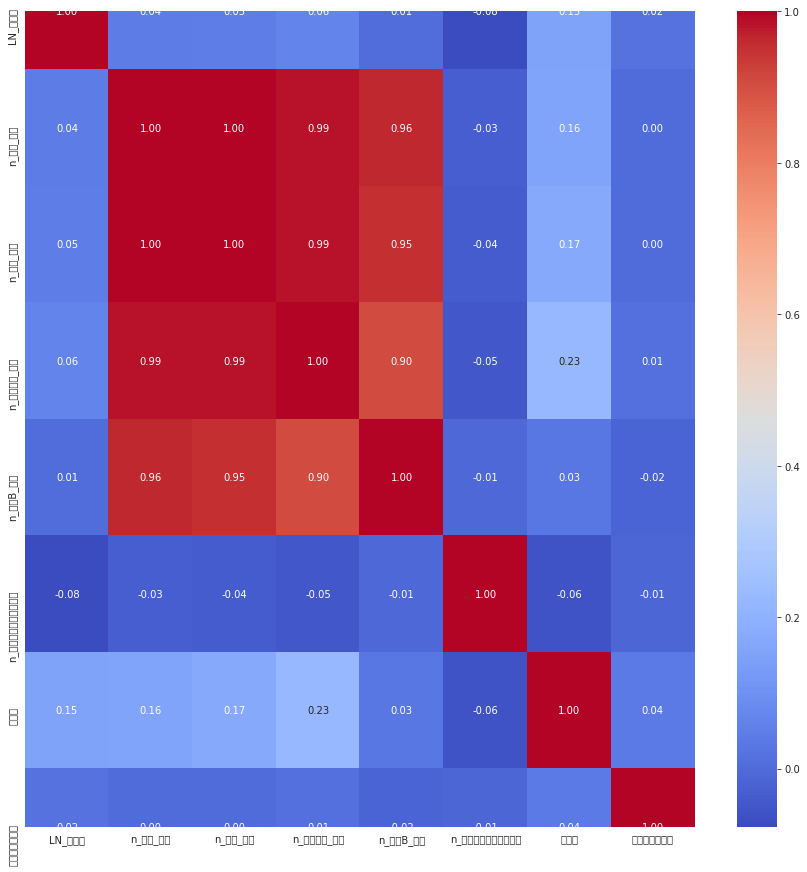

In [0]:
# 데이터 간의 상관관계 체크
# 수치형변수들과 Survived 변수의 상관관계 Matrix 시각화
plt.figure(figsize=(15, 15))
g = sns.heatmap(df_iv_top.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

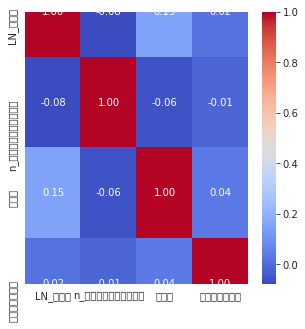

In [0]:
# del_corr_inputs = ['n_정밀검진_권고', 'n_관리_권고','n_치료필요_결과','n_정상A_결과','n_주의_결과','n_영양_교육','n_정상B_결과','n_불소_교육','n_위생_교육','n_우식필요_권고']
# del_corr_inputs = ['n_정밀검진_권고', 'n_관리_권고','n_정상B_결과','n_불소_교육'] # iv >= 0.002
# del_corr_inputs = ['n_영양_교육', 'n_정상A_결과', 'n_주의_결과', 'n_치료필요_결과'] # iv >= 0.015
del_corr_inputs = ['n_관리_권고','n_정상B_결과','n_불소_교육','n_우식필요_권고'] # iv >= 0.008
df_iv_result = df_iv_top.drop(columns=del_corr_inputs, axis=1).copy()

plt.figure(figsize=(5, 5))
g = sns.heatmap(df_iv_result.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

### 4-5. 최종 모델 입력 변수 선정

In [0]:
# Feature Engineering 이후 불필요컬럼 Drop

# 치석, 결손치 유무와 같은 치아관련 변수 없이 모델 돌릴 시 # test set accuracy 수준: 56%

# 1. 상관관계 기준 최소 변수 선정 # test set accuracy 수준: 60.4%
# need_cols = ['치석'] + [target_nm] 

# 2. 치아검사 기준 최소 변수 선정 # test set accuracy 수준: 60.5%
# need_cols = ['치석','결손치유무'] + [target_nm] 

# 3. 외부변수 제외 모델링 # test set accuracy 수준: 62.9%
# need_cols = ['A_BMI', 'A_CRE', 'A_GTP', 'A_HDL', 'A_HEMO', 'A_LDL', 'A_TRI', 'A_diabetes', 'A_성별', 'A_시도', 'A_연령대5세단위', 'A_요단백', 'A_음주여부',
#        'A_청력우', 'A_청력좌', 'A_흡연상태', 'LN_HDL콜레스테롤', 'LN_LDL콜레스테롤','LN_감마지티피', 'LN_시력우', 'LN_시력좌', 'LN_식전혈당공복혈당', 'LN_트리글리세라이드',
#        'LN_혈청지오티ALT', 'LN_혈청지오티AST', 'LN_혈청크레아티닌', 'n_관리_권고', 'n_불소_교육',
#        '결손치유무', '수축기혈압', '신장5Cm단위', '이완기혈압','체중5Kg단위', '총콜레스테롤', '치석', '치아우식증유무', '허리둘레', '혈색소']

# 4. Information Value 기준 변수 선정(외부변수 추가) # test set accuracy 수준: 62.9%
need_cols = df_iv_result.columns

# # 5. 최종 모델에 입력 될 변수 선정(수치형 LN 기준 입력) # test set accuracy 수준: 63%
# # need_cols = list(set(df_new.columns) - (set(num_ln_target_features + remove_target_candidates) - set([target_nm])))
# need_cols = list(set(df_new.columns) - (set(num_ln_target_features + remove_target_candidates) - set([target_nm] + not_remove_in_tg))) 

df_final = df_new[need_cols].copy()
df_final.columns

Index(['A_성별', 'A_시도', 'A_연령대5세단위', 'A_음주여부', 'A_흡연상태', 'LN_시력우',
       'n_치과병원평균수진횟수', '결손치유무', '신장5Cm단위', '체중5Kg단위', '치석', '혈색소', '치아우식증유무'],
      dtype='object')

## 5. 모델 입력 전 최종 모델 입력에 맞게 입력 데이터 변형

In [0]:
data_x = df_final[df_final.columns.difference([target_nm])]
data_y = df_final[target_nm].astype('float64')

In [0]:
num_attribs = [col for col in data_x.columns if data_x[col].dtype in ['int64','float64']]
cat_attribs = [col for col in data_x.columns if data_x[col].dtype not in ['int64','float64']]

num_attribs = list(set(num_attribs) - set([target_nm]))

print("num_attribs: ", num_attribs)
print("cat_attribs: ", cat_attribs)

num_attribs:  ['LN_시력우', '혈색소', 'n_치과병원평균수진횟수']
cat_attribs:  ['A_성별', 'A_시도', 'A_연령대5세단위', 'A_음주여부', 'A_흡연상태', '결손치유무', '신장5Cm단위', '체중5Kg단위', '치석']


### 5-1. 수치형 변수 정규화 및 Pipeline 연결



In [0]:
# Feature Engineering의 일환으로 Log 값 취한 뒤 Normalization을 하여 변수명 + LN (lognorm)으로 열 추가 후 그래프 다시 그림
num_pipeline = Pipeline([
        ('min_max_scaler', MinMaxScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, num_attribs),
        ("cat_encoder", OneHotEncoder(sparse=False), cat_attribs),
    ])

data_x_piped = full_pipeline.fit_transform(data_x)

data_y_piped = data_y.values

### 5-2. Train & Test 데이터 분리

In [0]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(data_x_piped, data_y_piped, test_size = 0.2, random_state = set_random_seed)

In [0]:
display(train_x.shape)
display(test_x.shape)
display(train_y.shape)
display(test_y.shape)

(240000, 79)

(60000, 79)

(240000,)

(60000,)

### 5-3. 모델 선정 및 선언

In [0]:
#Machine Learning Algorithm (MLA) 선택 및 초기화

# 1차 Test 후 좋은 성능을 보인 모델 
# ['LogisticRegressionCV', 'RidgeClassifierCV', 'AdaBoostClassifier', 'GradientBoostingClassifier', 'LinearDiscriminantAnalysis', 'XGBClassifier']
MLA = [ 
    #GLM
    linear_model.LogisticRegressionCV(),
    # linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    # linear_model.SGDClassifier(),
    # linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    # naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    # neighbors.KNeighborsClassifier(),

    #Gaussian Processes
    # gaussian_process.GaussianProcessClassifier(),

    #Trees    
    # tree.DecisionTreeClassifier(),
    # tree.ExtraTreeClassifier(),

    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    # ensemble.BaggingClassifier(),
    # ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    # ensemble.RandomForestClassifier(),
       
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    # discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    #SVM
    # svm.SVC(probability=True),
    # svm.NuSVC(probability=True),
    # svm.LinearSVC(),   

    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()
    ]

#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits=3, test_size=.3, train_size =.6, random_state=42) # run model 10x with 60/30 split intentionally leaving out 10%

In [0]:
# 모델평가를 위한 변수 세팅
score_pram = ['accuracy', 'precision','recall','f1']

#Create Table to Compare Canonical Models
MLA_Result_columns = ['ModelName','Dataset','Accuracy','Precision','Recall','F1']
MLA_compare = pd.DataFrame(columns = MLA_Result_columns)

#create table to compare MLA predictions
MLA_predict = pd.DataFrame(train_y)
print(MLA_predict.shape)

(240000, 1)


### 5-4. Model 실행 with Cross Validation

In [0]:
# index through MLA and save performance to table
row_index = 0
cv = set_cv
# 알고리즘을 하나씩 꺼내면서 loop
for alg in tqdm_notebook(MLA):
    print(alg, "algorithm modeling starts ... ")
    #알고리즘의 이름은 할당하고, [row_index, MLA Name]에 이름을 넣고, [row_index, MLA Parameters]에 알고리즘의 파라미터들을 할당
    Model_Name = alg.__class__.__name__
    
    cv_results = cross_validate(alg, train_x, train_y, cv=cv, scoring=score_pram, return_train_score=True, n_jobs=-1, verbose=1)
    
    train_cnt = 0
    test_cnt = 0
    
    for i in cv_results.keys():
      if("train" in i and train_cnt == 0):
        MLA_compare.loc[row_index, 'ModelName'] = Model_Name
        MLA_compare.loc[row_index, 'Dataset'] = "TrainSet"
        MLA_compare.loc[row_index, 'Accuracy'] = format(cv_results['train_accuracy'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'Precision'] = format(cv_results['train_precision'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'Recall'] = format(cv_results['train_recall'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'F1'] = format(cv_results['train_f1'].mean(), "10.4f")
        row_index+=1
        train_cnt+=1
      elif("test" in i and test_cnt ==0):
        MLA_compare.loc[row_index, 'ModelName'] = Model_Name
        MLA_compare.loc[row_index, 'Dataset'] = "TestSet"
        MLA_compare.loc[row_index, 'Accuracy'] = format(cv_results['test_accuracy'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'Precision'] = format(cv_results['test_precision'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'Recall'] = format(cv_results['test_recall'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'F1'] = format(cv_results['test_f1'].mean(), "10.4f")
        row_index+=1
        test_cnt+=1

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]), class_weight=None, cv=None,
                  fit_intercept=True, normalize=False, scoring=None,
                  store_cv_values=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   54.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   54.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1) algorithm modeling starts ... 



[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   44.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   44.4s finished


In [0]:
MLA_compare

,ModelName,Dataset,Accuracy,Precision,Recall,F1
0,LogisticRegressionCV,TestSet,0.6245,0.6261,0.6200,0.6230
1,LogisticRegressionCV,TrainSet,0.6250,0.6266,0.6204,0.6235
2,RidgeClassifierCV,TestSet,0.6247,0.6262,0.6201,0.6232
3,RidgeClassifierCV,TrainSet,0.6248,0.6264,0.6200,0.6232
4,BernoulliNB,TestSet,0.6089,0.6104,0.6044,0.6074
5,BernoulliNB,TrainSet,0.6090,0.6104,0.6044,0.6074
6,AdaBoostClassifier,TestSet,0.6245,0.6257,0.6215,0.6236
7,AdaBoostClassifier,TrainSet,0.6251,0.6262,0.6225,0.6243
8,GradientBoostingClassifier,TestSet,0.6240,0.6251,0.6215,0.6232
9,GradientBoostingClassifier,TrainSet,0.6267,0.6277,0.6243,0.6260


In [0]:
model_xg_model = XGBClassifier().fit(train_x, train_y)
pred_y_xg = model_xg_model.predict_proba(test_x)
pred_y_xg

array([[0.5823976 , 0.41760242],
       [0.3665554 , 0.6334446 ],
       [0.3674788 , 0.6325212 ],
       ...,
       [0.48692983, 0.51307017],
       [0.51135206, 0.48864797],
       [0.40947884, 0.59052116]], dtype=float32)

In [0]:
# len(pred_y_xg)
# score_df_xg['proba_y'].values

In [0]:
score_df_xg = pd.DataFrame(columns=['proba_y', 'real_y'])
# print(len(pred_y_xg[:,1]), len(test_y))

score_df_xg['proba_y'] = pred_y_xg[:,1]
score_df_xg['real_y'] = test_y

score_df_xg = score_df_xg.sort_values(by="proba_y", ascending=False)

score_df_xg["prob_bin"] = score_df_xg['proba_y'].apply(lambda x: str(x)[:3])

In [0]:
f={'proba_y':['count'], 'real_y':['sum']}
score_final = score_df_xg.groupby(["prob_bin"]).agg(f)
display(score_final)
score_final['accuracy'] = score_final['real_y'].values/score_final['proba_y'].values
score_final['portion'] = score_final['real_y'].values/len(score_final)
score_final

,proba_y,real_y
,count,sum
prob_bin,,
0.1,190,20.0
0.2,5158,1306.0
0.3,10673,3516.0
0.4,13411,6080.0
0.5,15090,8316.0
0.6,11278,7401.0
0.7,2974,2209.0
0.8,1225,1046.0


,proba_y,real_y,accuracy,portion
,count,sum,,
prob_bin,,,,
0.1,190,20.0,0.105263,2.222222
0.2,5158,1306.0,0.253199,145.111111
0.3,10673,3516.0,0.329429,390.666667
0.4,13411,6080.0,0.453359,675.555556
0.5,15090,8316.0,0.551093,924.000000
0.6,11278,7401.0,0.656233,822.333333
0.7,2974,2209.0,0.742771,245.444444
0.8,1225,1046.0,0.853878,116.222222


### AUC Graph 그리는 함수 선언

In [0]:
def auc_graph(roc_auc, fpr, tpr):
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

In [0]:
# Deep Learning 평가를 위한 평가 함수 정의
from keras import backend as K

def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [0]:
def creat_dl_model(activation = 'relu', optimizer = 'rmsprop', epochs= 5, batch_size=64, init='glorot_uniform'):
  input_dim = train_x.shape[1]
  # batch_size = 64
#   epochs = 50
  print("activation is  ", activation, ", optimizer is  ", optimizer, ", epochs are ", epochs , ", batch_size is ", batch_size, ", init is ", init)

  model = Sequential()

  # 첫 번째 Layer (Input layer)
  model.add(Dense(input_dim=input_dim, init=init, activation=activation, output_dim=128))
  # model.add(Dropout(0.2)) # 30% 정도를 Drop 

  # 두 번째 Layer (Hidden layer 1)
  model.add(Dense(output_dim=128, init=init, activation=activation))
  # model.add(Dropout(0.2)) # 30% 정도를 Drop 

  # 세 번째 Layer (Hidden layer 2)
  model.add(Dense(output_dim=256, init=init, activation=activation))
  # model.add(Dropout(0.2)) # 30% 정도를 Drop 

  # 네 번째 Layer (Hidden layer 3)
  model.add(Dense(output_dim=512, init=init, activation=activation))
  # model.add(Dropout(0.2)) # 30% 정도를 Drop 

  # # 다섯 번째 Layer (Hidden layer 4)
  model.add(Dense(output_dim=512, init=init, activation=activation))
  model.add(Dropout(0.3)) # 30% 정도를 Drop 

  # 여섯 번째 Layer (Output layer)
  model.add(Dense(output_dim=1))
  model.add(Activation("sigmoid"))

  # Cost function 및 Optimizer 설정 # binary class 분류이므로 binary_crossentropy 사용 # Adam optimizer 사용
  # ffn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, f1score])
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', precision, recall, f1score])
  
  return model

In [0]:
model_dl = KerasClassifier(build_fn=creat_dl_model, verbose=2)

# grid search epochs, batch size and optimizer
# optimizers = ['rmsprop', 'adam']
# optimizers = ['adam', 'Nadam', 'Adadelta']
optimizers = ['adam']

# lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)
# activations = [lrelu, 'relu', 'tanh']
# activations = ['elu', 'tanh']
activations = ['tanh']

# init = ['glorot_uniform', 'normal', 'uniform']
init = ['glorot_uniform']

epochs = [10,15]

# batches = [10, 50, 100]
# batches = [64,128]
batches = [64]

print("Total iteration will be ", len(optimizers) * len(activations) * len(init) * len(epochs) * len(batches))

param_grid = dict(optimizer=optimizers, activation = activations, epochs=epochs, batch_size=batches, init=init)

cv = set_cv
grid = GridSearchCV(estimator=model_dl, param_grid=param_grid, cv=cv)
grid_result = grid.fit(train_x, train_y)

Total iteration will be  2
activation is   tanh , optimizer is   adam , epochs are  10 , batch_size is  64 , init is  glorot_uniform
Epoch 1/10
 - 15s - loss: 0.6567 - acc: 0.6145 - precision: 0.6165 - recall: 0.6085 - f1score: 0.6059
Epoch 2/10
 - 14s - loss: 0.6520 - acc: 0.6192 - precision: 0.6209 - recall: 0.6136 - f1score: 0.6119
Epoch 3/10
 - 14s - loss: 0.6520 - acc: 0.6209 - precision: 0.6229 - recall: 0.6156 - f1score: 0.6137
Epoch 4/10
 - 14s - loss: 0.6518 - acc: 0.6206 - precision: 0.6220 - recall: 0.6162 - f1score: 0.6136
Epoch 5/10
 - 14s - loss: 0.6516 - acc: 0.6207 - precision: 0.6217 - recall: 0.6214 - f1score: 0.6158
Epoch 6/10
 - 14s - loss: 0.6509 - acc: 0.6213 - precision: 0.6227 - recall: 0.6183 - f1score: 0.6151
Epoch 7/10
 - 14s - loss: 0.6506 - acc: 0.6217 - precision: 0.6231 - recall: 0.6193 - f1score: 0.6154
Epoch 8/10
 - 14s - loss: 0.6498 - acc: 0.6228 - precision: 0.6244 - recall: 0.6194 - f1score: 0.6159
Epoch 9/10
 - 14s - loss: 0.6497 - acc: 0.6220 - pr

In [0]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

### 개별 모델 테스트

In [0]:
# Deep Learning Single 모델 돌릴 때 사용

# model training
lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)
activation = lrelu

model_dl1 = KerasClassifier(build_fn = creat_dl_model, optimizer= 'adam', activation = 'tanh', epochs=5, batch_size=64, init='glorot_uniform')
model_dl2 = KerasClassifier(build_fn = creat_dl_model, optimizer= 'adam', activation = 'elu', epochs=10, batch_size=64, init='glorot_uniform')
model_dl3 = KerasClassifier(build_fn = creat_dl_model, optimizer= 'adam', activation = lrelu, epochs=10, batch_size=64, init='glorot_uniform')

In [0]:
model_dl1_run = model_dl1.fit(train_x, train_y)
pred_y_dl1 = model_dl1.predict(test_x)
pred_y_dl1 = (pred_y_dl1>0.5)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_dl1)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_dl1))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_dl1))

roc_auc_dl1 = roc_auc_score(test_y, pred_y_dl1)
print("roc_auc score is : ", roc_auc_dl1)

fpr, tpr, threshold = roc_curve(test_y, pred_y_dl1)
roc_auc = auc(fpr, tpr)

auc_graph(roc_auc, fpr, tpr)

In [0]:
model_dl2_run = model_dl2.fit(train_x, train_y)

pred_y_dl2 = model_dl2.predict(test_x)
pred_y_dl2 = (pred_y_dl2>0.5)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_dl2)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_dl2))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_dl2))

roc_auc_dl2 = roc_auc_score(test_y, pred_y_dl2)
print("roc_auc score is : ", roc_auc_dl2)

fpr, tpr, threshold = roc_curve(test_y, pred_y_dl2)
roc_auc = auc(fpr, tpr)

auc_graph(roc_auc, fpr, tpr)

In [0]:
model_dl3_run = model_dl3.fit(train_x, train_y)

pred_y_dl3 = model_dl3.predict(test_x)
pred_y_dl3 = (pred_y_dl3>0.5)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_dl3)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_dl3))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_dl3))

roc_auc_dl3 = roc_auc_score(test_y, pred_y_dl3)
print("roc_auc score is : ", roc_auc_dl3)

fpr, tpr, threshold = roc_curve(test_y, pred_y_dl3)
roc_auc = auc(fpr, tpr)

auc_graph(roc_auc, fpr, tpr)

### 성능이 좋은 모델들의 Hyperparameter Tuning

In [0]:
cv_split = ShuffleSplit(n_splits=3, test_size=.3, train_size =.6, random_state=set_random_seed) # run model 10x with 60/30 split intentionally leaving out 10%
verboseNo = 1

In [0]:
# LogisticRegressionCV
model_lr = linear_model.LogisticRegression()

param_grid = {'C': np.logspace(-3,3,7), 'penalty': ['l1', 'l2']}

grid_lr = GridSearchCV(model_lr,param_grid = param_grid, cv=cv_split, scoring="f1", n_jobs= -1, verbose = verboseNo)
grid_lr.fit(train_x, train_y)
grid_lr_best = grid_lr.best_estimator_
print(grid_lr_best)

In [0]:
pred_y_lr = grid_lr_best.predict(test_x)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_lr)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_lr))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_lr))

roc_auc_lr = roc_auc_score(test_y, pred_y_lr)
print(roc_auc_lr)

fpr, tpr, threshold = roc_curve(test_y, pred_y_lr)
roc_auc = auc(fpr, tpr)

auc_graph(roc_auc, fpr, tpr)

In [0]:
# RidgeClassifierCV
model_rc = linear_model.RidgeClassifier()

param_grid = {'alpha':[1e-3, 1e-2, 1e-1, 1]}

grid_rc = GridSearchCV(model_rc,param_grid = param_grid, cv=cv_split, scoring="f1", n_jobs= -1, verbose = verboseNo)
grid_rc.fit(train_x, train_y)
grid_rc_best = grid_rc.best_estimator_
print(grid_rc_best)

In [0]:
pred_y_rc = grid_rc_best.predict(test_x)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_rc)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_rc))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_rc))

roc_auc_rc = roc_auc_score(test_y, pred_y_rc)
print("AUC Score : {:.5f}".format(roc_auc_rc))

fpr, tpr, threshold = roc_curve(test_y, pred_y_rc)
roc_auc = auc(fpr, tpr)

auc_graph(roc_auc, fpr, tpr)

In [0]:
# AdaBoostClassifier
model_ab = ensemble.AdaBoostClassifier()

param_grid = {'n_estimators': [16, 32]}

grid_ab = GridSearchCV(model_ab,param_grid = param_grid, cv=cv_split, scoring="f1", n_jobs= -1, verbose = verboseNo)
grid_ab.fit(train_x, train_y)
grid_ab_best = grid_ab.best_estimator_
print(grid_ab_best)

In [0]:
pred_y_ab = grid_ab_best.predict(test_x)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_ab)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_ab))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_ab))

roc_auc_ab = roc_auc_score(test_y, pred_y_ab)
print("AUC Score : {:.5f}".format(roc_auc_ab))

fpr, tpr, threshold = roc_curve(test_y, pred_y_ab)
roc_auc = auc(fpr, tpr)

auc_graph(roc_auc, fpr, tpr)

In [0]:
# GradientBoostingClassifier
model_gb = ensemble.GradientBoostingClassifier()

param_grid = {'n_estimators': [16, 32], 'learning_rate': [0.8, 1.0]}

grid_gb = GridSearchCV(model_gb,param_grid = param_grid, cv=cv_split, scoring="f1", n_jobs= -1, verbose = verboseNo)
grid_gb.fit(train_x, train_y)
grid_gb_best = grid_gb.best_estimator_
print(grid_gb_best)

In [0]:
pred_y_gb = grid_gb_best.predict(test_x)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_gb)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_gb))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_gb))

roc_auc_gb = roc_auc_score(test_y, pred_y_gb)
print("AUC Score : {:.5f}".format(roc_auc_gb))

fpr, tpr, threshold = roc_curve(test_y, pred_y_gb)
roc_auc = auc(fpr, tpr)

auc_graph(roc_auc, fpr, tpr)

In [0]:
# LinearDiscriminantAnalysis
## LDA(선형판별분석(Linear Discriminant Analysis):데이터를 특정 한 축에 사영(projection)한 후에 두 범주를 잘 구분할 수 있는 직선을 찾는 걸 목표
model_ld = discriminant_analysis.LinearDiscriminantAnalysis()

param_grid = {'solver': ['svd', 'lsqr']}

grid_ld = GridSearchCV(model_ld,param_grid = param_grid, cv=cv_split, scoring="f1", n_jobs= -1, verbose = verboseNo)
grid_ld.fit(train_x, train_y)
grid_ld_best = grid_ld.best_estimator_
print(grid_ld_best)

In [0]:
pred_y_ld = grid_ld_best.predict(test_x)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_ld)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_ld))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_ld))

roc_auc_ld = roc_auc_score(test_y, pred_y_ld)
print("AUC Score : {:.5f}".format(roc_auc_ld))

fpr, tpr, threshold = roc_curve(test_y, pred_y_ld)
roc_auc = auc(fpr, tpr)

auc_graph(roc_auc, fpr, tpr)

In [0]:
# XGBClassifier
model_xg = XGBClassifier()

param_grid = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [6],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [5], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}

grid_xg = GridSearchCV(model_xg,param_grid = param_grid, cv=cv_split, scoring="f1", n_jobs= -1, verbose = verboseNo)
grid_xg.fit(train_x, train_y)
grid_xg_best = grid_xg.best_estimator_
print(grid_xg_best)

In [0]:
pred_y_xg = grid_xg_best.predict(test_x)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_xg)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_xg))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_xg))

roc_auc_xg = roc_auc_score(test_y, pred_y_xg)
print("AUC Score : {:.5f}".format(roc_auc_xg))

fpr, tpr, threshold = roc_curve(test_y, pred_y_xg)
roc_auc = auc(fpr, tpr)

auc_graph(roc_auc, fpr, tpr)

In [0]:
# # XGBoost Test
# xgb_clf = XGBClassifier(nthreads=-1)

# one_to_left = st.beta(100, 1)  
# from_zero_positive = st.expon(0, 50)

# params = {  
#     "n_estimators": st.randint(3, 100),
#     "max_depth": st.randint(3, 40),
#     "learning_rate": st.uniform(0.05, 0.9),
#     "colsample_bytree": one_to_left,
#     "subsample": one_to_left,
#     "gamma": st.uniform(0, 10),
#     'reg_alpha': from_zero_positive,
#     "min_child_weight": from_zero_positive,
# }

# rand_search = RandomizedSearchCV(xgb_clf, params, n_jobs=1, cv=100)  
# rand_search.fit(x_train, y_train) 
# xgb_best = rand_search.best_estimator_
# print(rand_search.best_estimator_)

## 결과 앙상블로 모델 결과 최적화

In [0]:
votingC = VotingClassifier(estimators=[('model_lr',grid_lr_best),('model_ab', grid_ab_best),
                                       ('model_gb', grid_gb_best),('model_ld', grid_ld_best), ('model_xg',grid_xg_best)], 
                           voting='soft', n_jobs=-1)

votingC = votingC.fit(train_x, train_y)

In [0]:
# soft voting을 통한 성능 향상
pred_y_vc = votingC.predict(test_x)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_vc)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_vc))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_vc))

roc_auc_vc = roc_auc_score(test_y, pred_y_vc)
print("AUC Score : {:.5f}".format(roc_auc_vc))

fpr, tpr, threshold = roc_curve(test_y, pred_y_vc)
roc_auc = auc(fpr, tpr)

auc_graph(roc_auc, fpr, tpr)

In [0]:
votingC1 = VotingClassifier(estimators=[('model_lr',grid_lr_best),('model_ab', grid_ab_best),('model_gb', grid_gb_best)
                                       ,('model_ld', grid_ld_best), ('model_xg',grid_xg_best), ('model_dl',model_dl)], 
                           voting='soft')

votingC1 = votingC1.fit(train_x, train_y)

In [0]:
# soft voting을 통한 성능 향상
pred_y_vc1 = votingC1.predict(test_x)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_vc1)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_vc1))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_vc1))

roc_auc_vc1 = roc_auc_score(test_y, pred_y_vc1)
print("AUC Score : {:.5f}".format(roc_auc_vc1))

fpr, tpr, threshold = roc_curve(test_y, pred_y_vc1)
roc_auc = auc(fpr, tpr)

auc_graph(roc_auc, fpr, tpr)